<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%87%BC%ED%95%91%EB%AA%B0_%EC%A7%80%EC%A0%90%EB%B3%84_%EB%A7%A4%EC%B6%9C%EC%95%A1_%EC%98%88%EC%B8%A1_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


쇼핑몰 지점별 매출액 예측 경진대회 https://dacon.io/competitions/official/235942/overview/description

# module

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 89 kB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# data lode

In [4]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# EDA

In [5]:
train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [7]:
train.isna().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [8]:
train.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales
count,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6.255000e+03
mean,3128.000000,23.000000,60.639199,3.344369,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,8.029236,1.047619e+06
std,1805.807299,12.988211,18.624094,0.455364,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,1.874875,5.654362e+05
min,1.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.410000,135.160000,4.077000,2.099862e+05
25%,1564.500000,12.000000,47.170000,2.917000,1844.295000,39.755000,4.700000,499.895000,1742.305000,6.916500,5.538695e+05
50%,3128.000000,23.000000,62.720000,3.413000,5221.140000,205.410000,24.600000,1532.630000,3226.410000,7.906000,9.604761e+05
75%,4691.500000,34.000000,75.220000,3.722000,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,8.622000,1.421209e+06
max,6255.000000,45.000000,100.140000,4.308000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,14.313000,3.818686e+06


In [9]:
train.columns

Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

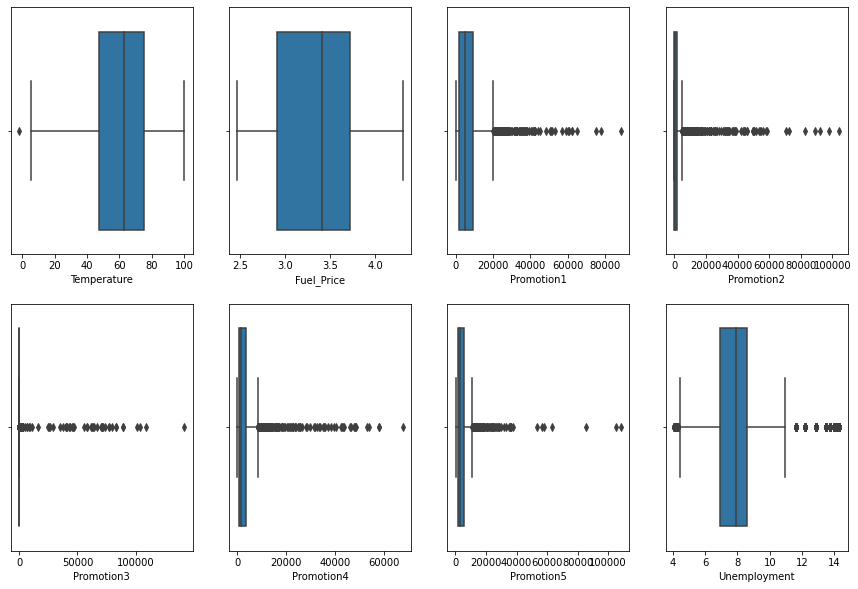

In [10]:
pltbox_list = ['Temperature', 'Fuel_Price', 'Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment']
plt.figure(figsize=(15,10))
for i in range(len(pltbox_list)):
    plt.subplot(2,4,i+1)
    sns.boxplot(train[pltbox_list[i]])
plt.show()

In [11]:
test.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday
0,1,1,05/10/2012,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,6.573,False
1,2,1,12/10/2012,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,6.573,False
2,3,1,19/10/2012,67.97,3.594,950.33,NaN,4.93,80.25,2312.85,6.573,False
3,4,1,26/10/2012,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,False
4,5,2,05/10/2012,70.27,3.617,6037.76,NaN,10.04,3027.37,3853.40,6.170,False


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            180 non-null    int64  
 1   Store         180 non-null    int64  
 2   Date          180 non-null    object 
 3   Temperature   180 non-null    float64
 4   Fuel_Price    180 non-null    float64
 5   Promotion1    178 non-null    float64
 6   Promotion2    45 non-null     float64
 7   Promotion3    161 non-null    float64
 8   Promotion4    146 non-null    float64
 9   Promotion5    180 non-null    float64
 10  Unemployment  180 non-null    float64
 11  IsHoliday     180 non-null    bool   
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 15.8+ KB


In [13]:
test.isna().sum()

id                0
Store             0
Date              0
Temperature       0
Fuel_Price        0
Promotion1        2
Promotion2      135
Promotion3       19
Promotion4       34
Promotion5        0
Unemployment      0
IsHoliday         0
dtype: int64

## Store

In [14]:
train.Store.value_counts()

1     139
24    139
26    139
27    139
28    139
29    139
30    139
31    139
32    139
33    139
34    139
35    139
36    139
37    139
38    139
39    139
40    139
41    139
42    139
43    139
44    139
25    139
23    139
2     139
22    139
3     139
4     139
5     139
6     139
7     139
8     139
9     139
10    139
11    139
12    139
13    139
14    139
15    139
16    139
17    139
18    139
19    139
20    139
21    139
45    139
Name: Store, dtype: int64

In [15]:
test.Store.value_counts()

1     4
24    4
26    4
27    4
28    4
29    4
30    4
31    4
32    4
33    4
34    4
35    4
36    4
37    4
38    4
39    4
40    4
41    4
42    4
43    4
44    4
25    4
23    4
2     4
22    4
3     4
4     4
5     4
6     4
7     4
8     4
9     4
10    4
11    4
12    4
13    4
14    4
15    4
16    4
17    4
18    4
19    4
20    4
21    4
45    4
Name: Store, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


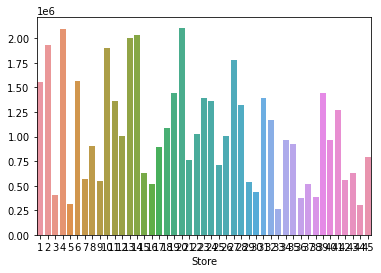

In [16]:
store_sales = train.groupby('Store').mean()['Weekly_Sales']
sns.barplot(store_sales.index,store_sales.values)
plt.show()

## Date(to_datetime)

In [17]:
train['Week'] = pd.to_datetime(train.Date, format='%d/%m/%Y').dt.week
train['Year'] = pd.to_datetime(train.Date, format='%d/%m/%Y').dt.year
train['Month'] = pd.to_datetime(train.Date, format='%d/%m/%Y').dt.month
test['Week'] = pd.to_datetime(test.Date, format='%d/%m/%Y').dt.week
test['Year'] = pd.to_datetime(test.Date, format='%d/%m/%Y').dt.year
test['Month'] = pd.to_datetime(test.Date, format='%d/%m/%Y').dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [ ]:
train_dd = train.copy()
train_dd['day'] = pd.to_datetime(train_dd.Date, format='%d/%m/%Y').dt.day

train_dd['day'].value_counts()

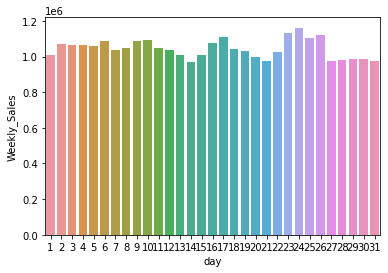

In [459]:
aa = train_dd.groupby('day').mean()['Weekly_Sales']
sns.barplot(aa.index, aa)
plt.show()

In [18]:
train.Year.value_counts()

2011    2340
2010    2160
2012    1755
Name: Year, dtype: int64

In [19]:
test.Year.value_counts()

2012    180
Name: Year, dtype: int64

In [20]:
train.Month.value_counts()

4     630
7     630
3     585
6     585
8     585
9     585
2     540
5     540
12    450
10    405
11    360
1     360
Name: Month, dtype: int64

In [21]:
test.Month.value_counts()

10    180
Name: Month, dtype: int64

In [22]:
train.Week.value_counts()

5     135
23    135
25    135
26    135
27    135
28    135
29    135
30    135
6     135
32    135
33    135
34    135
35    135
36    135
37    135
38    135
39    135
24    135
31    135
22    135
13    135
21    135
7     135
8     135
9     135
11    135
12    135
10    135
14    135
15    135
16    135
17    135
18    135
19    135
20    135
48     90
3      90
2      90
1      90
52     90
51     90
50     90
49     90
40     90
47     90
46     90
45     90
44     90
43     90
42     90
41     90
4      90
Name: Week, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


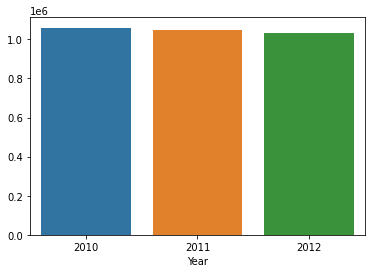

In [23]:
year_slaes = train.groupby('Year').mean()['Weekly_Sales']
sns.barplot(year_slaes.index,year_slaes.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


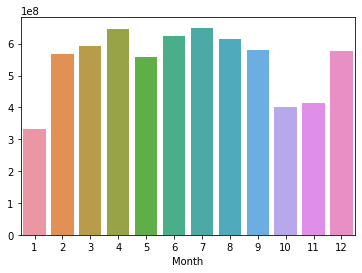

In [24]:
month_slaes = train.groupby('Month').sum()['Weekly_Sales']
sns.barplot(month_slaes.index,month_slaes.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


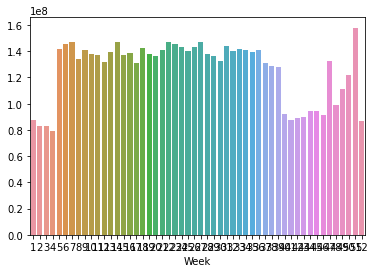

In [25]:
week_slaes = train.groupby('Week').sum()['Weekly_Sales']
sns.barplot(week_slaes.index,week_slaes.values)
plt.show()

## Temperature

In [26]:
train[train['Temperature'] == train['Temperature'].min()]

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Week,Year,Month
886,887,7,04/02/2011,-2.06,3.011,NaN,NaN,NaN,NaN,NaN,8.818,False,558027.77,5,2011,2


In [27]:
train[(train['Store']==7) & (train['Month']==2)]

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Week,Year,Month
834,835,7,05/02/2010,10.53,2.580,NaN,NaN,NaN,NaN,NaN,9.014,False,496725.44,5,2010,2
835,836,7,12/02/2010,25.90,2.572,NaN,NaN,NaN,NaN,NaN,9.014,True,524104.92,6,2010,2
836,837,7,19/02/2010,27.28,2.550,NaN,NaN,NaN,NaN,NaN,9.014,False,506760.54,7,2010,2
837,838,7,26/02/2010,24.91,2.586,NaN,NaN,NaN,NaN,NaN,9.014,False,496083.24,8,2010,2
886,887,7,04/02/2011,-2.06,3.011,NaN,NaN,NaN,NaN,NaN,8.818,False,558027.77,5,2011,2
887,888,7,11/02/2011,10.24,3.037,NaN,NaN,NaN,NaN,NaN,8.818,True,559903.13,6,2011,2
888,889,7,18/02/2011,17.30,3.051,NaN,NaN,NaN,NaN,NaN,8.818,False,572387.47,7,2011,2
889,890,7,25/02/2011,17.46,3.101,NaN,NaN,NaN,NaN,NaN,8.818,False,546690.84,8,2011,2
938,939,7,03/02/2012,22.20,3.031,56917.70,1839.82,4.53,16241.73,2414.97,8.256,False,580453.32,5,2012,2
939,940,7,10/02/2012,18.79,3.103,13100.37,3096.60,1.73,4854.70,6266.04,8.256,True,563460.77,6,2012,2


In [28]:
train.loc[train['Temperature'] == train['Temperature'].min(), 'Temperature'] = train[(train['Store']==7) & (train['Month']==2)]['Temperature'].mean()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


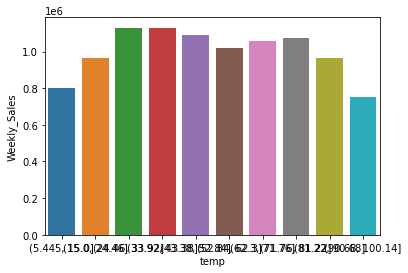

In [29]:
train_temp = train.copy()
train_temp['temp'] = pd.cut(train_temp['Temperature'], 10)
train_temp_g = train_temp.groupby('temp').mean()['Weekly_Sales']

sns.barplot(train_temp_g.index, train_temp_g)
plt.show()

## Fuel_Price

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


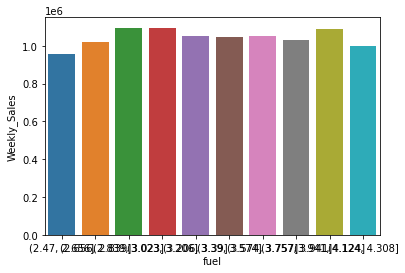

In [30]:
train_temp = train.copy()
train_temp['fuel'] = pd.cut(train_temp['Fuel_Price'], 10)
train_temp_g = train_temp.groupby('fuel').mean()['Weekly_Sales']

sns.barplot(train_temp_g.index, train_temp_g)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


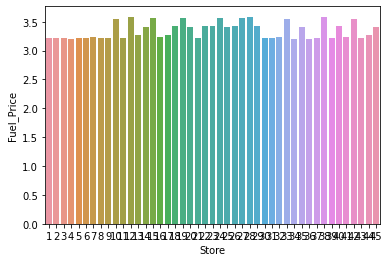

In [31]:
train_g = train.groupby('Store').mean()['Fuel_Price']
sns.barplot(train_g.index, train_g)
plt.show()

## Promotion

In [32]:
train.groupby('Year').mean()['Promotion1']

Year
2010            NaN
2011    4312.248588
2012    7731.825086
Name: Promotion1, dtype: float64

In [33]:
train.groupby('Year').mean()['Promotion2']

Year
2010            NaN
2011    7585.530273
2012    2343.322494
Name: Promotion2, dtype: float64

In [34]:
train.groupby('Year').mean()['Promotion3']

Year
2010            NaN
2011    7805.060702
2012      56.739274
Name: Promotion3, dtype: float64

In [35]:
train.groupby('Year').mean()['Promotion4']

Year
2010            NaN
2011    1507.795232
2012    3855.776823
Name: Promotion4, dtype: float64

In [36]:
train.groupby('Year').mean()['Promotion5']

Year
2010            NaN
2011    6128.216139
2012    4188.896154
Name: Promotion5, dtype: float64

In [37]:
train_pro = train.copy()
train_pro['pro'] = train.loc[:,'Promotion1':'Promotion5'].sum(axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


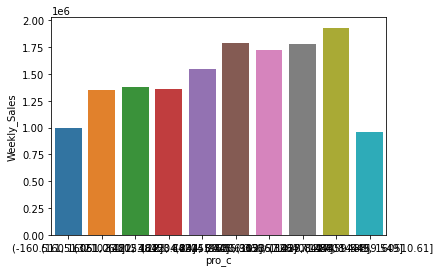

In [38]:
train_pro['pro_c'] = pd.cut(train_pro['pro'],10)
train_pro_g = train_pro.groupby('pro_c').mean()['Weekly_Sales']
sns.barplot(train_pro_g.index, train_pro_g)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

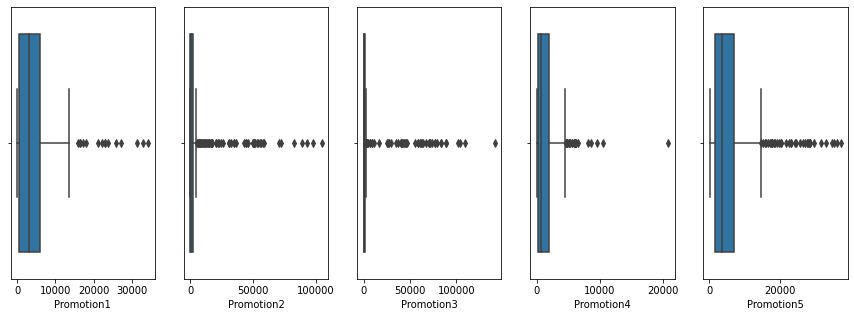

In [39]:
train_2011 = train[train['Year'] == 2011]
pltbox_list = ['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']
plt.figure(figsize=(15,5))
for i in range(len(pltbox_list)):
    plt.subplot(1,5,i+1)
    sns.boxplot(train_2011[pltbox_list[i]])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

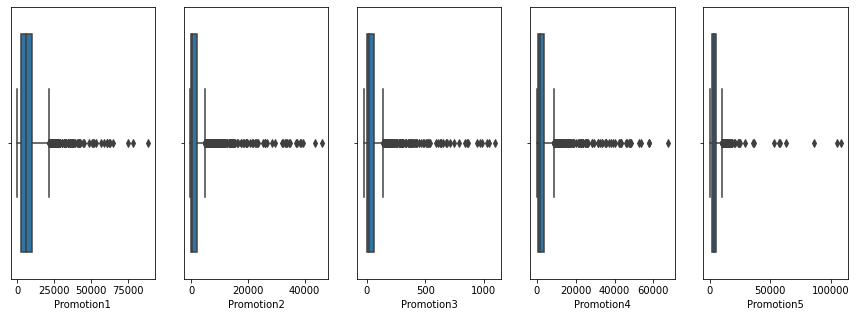

In [40]:
train_2012 = train[train['Year'] == 2012]
pltbox_list = ['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']
plt.figure(figsize=(15,5))
for i in range(len(pltbox_list)):
    plt.subplot(1,5,i+1)
    sns.boxplot(train_2012[pltbox_list[i]])
plt.show()

In [41]:
train['pro'] = train.loc[:,'Promotion1':'Promotion5'].sum(axis=1)
test['pro'] = test.loc[:,'Promotion1':'Promotion5'].sum(axis=1)

## Unemployment

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


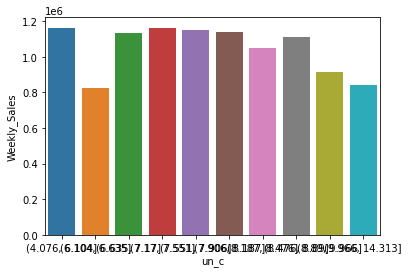

In [42]:
train_un = train.copy()
train_pro['un_c'] = pd.qcut(train_pro['Unemployment'],10)
train_pro_g = train_pro.groupby('un_c').mean()['Weekly_Sales']
sns.barplot(train_pro_g.index, train_pro_g)
plt.show()

## IsHoliday

In [43]:
train.IsHoliday.value_counts()

False    5805
True      450
Name: IsHoliday, dtype: int64

In [44]:
test.IsHoliday.value_counts()

False    180
Name: IsHoliday, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


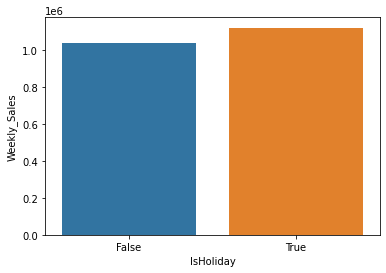

In [45]:
train_ho_g = train.groupby('IsHoliday').mean()['Weekly_Sales']
sns.barplot(train_ho_g.index, train_ho_g)
plt.show()

In [46]:
lae = LabelEncoder()
train['IsHoliday'] = lae.fit_transform(train[['IsHoliday']])
test['IsHoliday'] = lae.transform(test[['IsHoliday']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Store_Year

In [47]:
import warnings
warnings.filterwarnings('ignore')

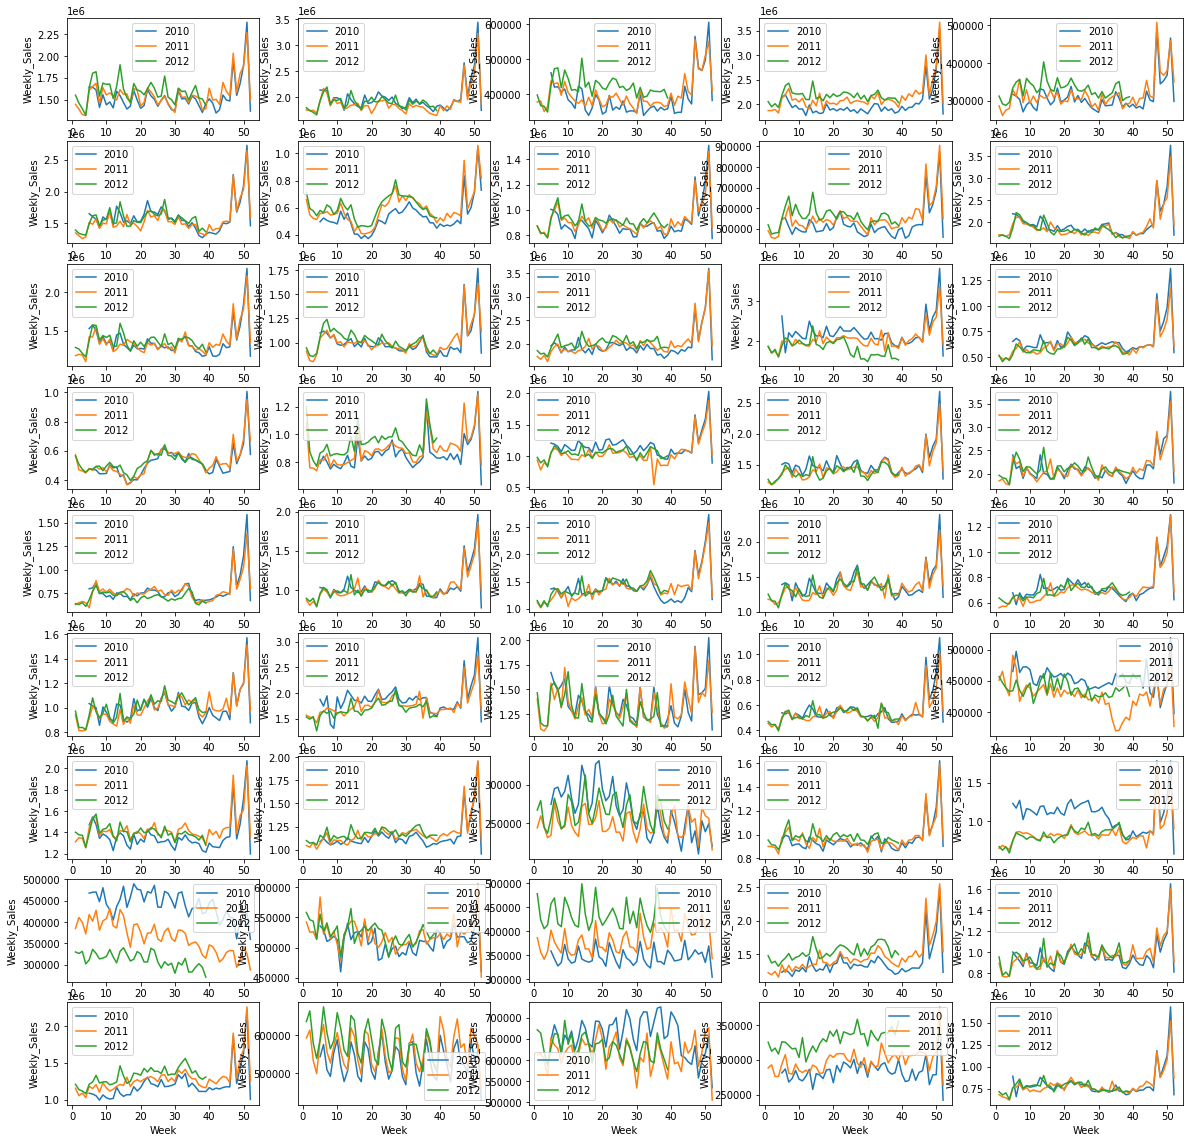

In [48]:
plt.figure(figsize=(20,20))
for i in range(1,46):
    plt.subplot(9,5,i)
    for j in [2010,2011,2012]:
        train_plt = train[(train['Store'] == i) & (train['Year'] == j)]
        sns.lineplot(train_plt['Week'], train_plt['Weekly_Sales'], label=j)
plt.legend()
plt.show()

## Standard, MinMax

In [49]:
sds, mms = StandardScaler(), MinMaxScaler()

In [50]:
sds, mms = StandardScaler(), MinMaxScaler()
sms = Pipeline([('sds',sds), ('mms', mms)])
def sms_t(x):
    train[x] = sms.fit_transform(train[[x]])
    test[x] = sms.fit_transform(test[[x]])
for i in ['Temperature', 'Fuel_Price', 'Unemployment','pro']:
    sms_t(i)

In [51]:
train.describe()

,id,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Week,Year,Month,pro
count,6255.000000,6255.000000,6255.000000,6255.000000,2102.000000,1592.000000,1885.000000,1819.000000,2115.000000,6255.000000,6255.000000,6.255000e+03,6255.000000,6255.000000,6255.000000,6255.000000
mean,3128.000000,23.000000,0.582479,0.475147,7155.930661,3308.125810,1462.535523,3465.952501,4518.993173,0.386111,0.071942,1.047619e+06,25.366906,2010.935252,6.345324,0.038773
std,1805.807299,12.988211,0.196774,0.248020,8408.206085,9382.823804,9667.580258,6413.116294,6048.661908,0.183165,0.258413,5.654362e+05,14.073468,0.788547,3.227195,0.089965
min,1.000000,1.000000,0.000000,0.000000,0.270000,-265.760000,-29.100000,0.410000,135.160000,0.000000,0.000000,2.099862e+05,1.000000,2010.000000,1.000000,0.000000
25%,1564.500000,12.000000,0.440063,0.242375,1844.295000,39.755000,4.700000,499.895000,1742.305000,0.277403,0.000000,5.538695e+05,13.000000,2010.000000,4.000000,0.000000
50%,3128.000000,23.000000,0.604440,0.512527,5221.140000,205.410000,24.600000,1532.630000,3226.410000,0.374072,0.000000,9.604761e+05,25.000000,2011.000000,6.000000,0.000000
75%,4691.500000,34.000000,0.736575,0.680828,9199.242500,1931.005000,104.010000,3640.905000,5444.030000,0.444021,0.000000,1.421209e+06,37.000000,2012.000000,9.000000,0.038599
max,6255.000000,45.000000,1.000000,1.000000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,1.000000,1.000000,3.818686e+06,52.000000,2012.000000,12.000000,1.000000


# modeling

In [174]:
knr = KNeighborsRegressor()
svr = SVR()
rfr = RandomForestRegressor()
xgb = XGBRegressor(objective='reg:squarederror',max_depth=4, learning_rate=0.1, n_estimators=150)
cat = CatBoostRegressor(verbose=0)
lgbm = LGBMRegressor()

In [55]:
train_t = train.copy()
train_t = train_t[['Store', 'Temperature', 'Fuel_Price', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'Week', 'Year', 'Month', 'pro']]
x_train_t = train_t[['Store', 'Temperature', 'Fuel_Price', 'Unemployment',
       'IsHoliday', 'Week', 'Year', 'Month', 'pro']]

## model select

### knr

In [64]:
knr_re_1 = []
knr_re_2 = []
knr_re_3 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = knr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    knr_re_1.append(re1)

    model = knr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    knr_re_2.append(re2)

    model = knr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    knr_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(knr_re_1),  np.mean(knr_re_2),  np.mean(knr_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 81586, re2 = 67802, re3 = 78822, select = 2011
 2 : re1 = 51686, re2 = 64528, re3 = 82674, select = 2010
 3 : re1 = 34250, re2 = 24586, re3 = 34469, select = 2011
 4 : re1 = 167639, re2 = 48668, re3 = 110818, select = 2011
 5 : re1 = 18290, re2 = 18183, re3 = 24050, select = 2011
 6 : re1 = 79282, re2 = 74843, re3 = 96259, select = 2011
 7 : re1 = 24797, re2 = 27357, re3 = 17238, select = 2012
 8 : re1 = 23477, re2 = 20863, re3 = 45688, select = 2011
 9 : re1 = 32503, re2 = 12876, re3 = 34313, select = 2011
10 : re1 = 35287, re2 = 14572, re3 = 24063, select = 2011
11 : re1 = 37420, re2 = 37935, re3 = 55961, select = 2010
12 : re1 = 51281, re2 = 34196, re3 = 34002, select = 2012
13 : re1 = 139685, re2 = 96094, re3 = 147115, select = 2011
14 : re1 = 361213, re2 = 301962, re3 = 300643, select = 2012
15 : re1 = 60020, re2 = 37363, re3 = 29176, select = 2012
16 : re1 = 33912, re2 = 32939, re3 = 20991, select = 2012
17 : re1 = 175919, re2 = 152442, re3 = 130877, select = 2012
18 :

### svr

In [65]:
svr_re_1 = []
svr_re_2 = []
svr_re_3 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = svr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    svr_re_1.append(re1)

    model = svr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    svr_re_2.append(re2)

    model = svr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    svr_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(svr_re_1),  np.mean(svr_re_2),  np.mean(svr_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 82300, re2 = 83120, re3 = 81793, select = 2012
 2 : re1 = 105370, re2 = 64219, re3 = 76704, select = 2011
 3 : re1 = 9467, re2 = 12725, re3 = 16136, select = 2010
 4 : re1 = 64102, re2 = 40763, re3 = 63280, select = 2011
 5 : re1 = 20059, re2 = 19906, re3 = 21365, select = 2011
 6 : re1 = 156339, re2 = 119481, re3 = 131582, select = 2011
 7 : re1 = 31368, re2 = 46175, re3 = 30598, select = 2012
 8 : re1 = 26863, re2 = 27817, re3 = 26847, select = 2012
 9 : re1 = 19693, re2 = 20506, re3 = 19347, select = 2012
10 : re1 = 155049, re2 = 132529, re3 = 151058, select = 2011
11 : re1 = 66650, re2 = 58030, re3 = 55071, select = 2012
12 : re1 = 88128, re2 = 90122, re3 = 82309, select = 2012
13 : re1 = 104491, re2 = 104459, re3 = 108888, select = 2011
14 : re1 = 423600, re2 = 322552, re3 = 395146, select = 2011
15 : re1 = 60468, re2 = 46466, re3 = 59123, select = 2011
16 : re1 = 25785, re2 = 27856, re3 = 26706, select = 2010
17 : re1 = 229450, re2 = 221587, re3 = 231605, select = 2011

### rfr

In [66]:
rfr_re_1 = []
rfr_re_2 = []
rfr_re_3 = []
rfr_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = rfr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    rfr_re_1.append(re1)

    model = rfr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    rfr_re_2.append(re2)

    model = rfr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    rfr_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    rfr_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(rfr_re_1),  np.mean(rfr_re_2),  np.mean(rfr_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 87236, re2 = 65984, re3 = 72820, select = 2011
 2 : re1 = 45705, re2 = 47976, re3 = 72526, select = 2010
 3 : re1 = 15728, re2 = 14468, re3 = 15000, select = 2011
 4 : re1 = 55090, re2 = 61280, re3 = 50035, select = 2012
 5 : re1 = 23915, re2 = 23738, re3 = 23870, select = 2011
 6 : re1 = 81934, re2 = 64198, re3 = 69951, select = 2011
 7 : re1 = 23348, re2 = 30516, re3 = 37586, select = 2010
 8 : re1 = 61557, re2 = 38967, re3 = 47582, select = 2011
 9 : re1 = 36411, re2 = 28643, re3 = 30025, select = 2011
10 : re1 = 78531, re2 = 30478, re3 = 21790, select = 2012
11 : re1 = 69228, re2 = 81545, re3 = 40963, select = 2012
12 : re1 = 89345, re2 = 57954, re3 = 16722, select = 2012
13 : re1 = 142671, re2 = 123730, re3 = 137464, select = 2011
14 : re1 = 182673, re2 = 152897, re3 = 156978, select = 2011
15 : re1 = 42347, re2 = 37770, re3 = 42295, select = 2011
16 : re1 = 29336, re2 = 18241, re3 = 14445, select = 2012
17 : re1 = 149391, re2 = 123098, re3 = 115271, select = 2012
18 : 

### xgb

In [72]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 69734, re2 = 59642, re3 = 50373, select = 2012
 2 : re1 = 29023, re2 = 67031, re3 = 65703, select = 2010
 3 : re1 = 14719, re2 = 14627, re3 = 14319, select = 2012
 4 : re1 = 64207, re2 = 44298, re3 = 10659, select = 2012
 5 : re1 = 23278, re2 = 18217, re3 = 17224, select = 2012
 6 : re1 = 103520, re2 = 42637, re3 = 72925, select = 2011
 7 : re1 = 23371, re2 = 41278, re3 = 28815, select = 2010
 8 : re1 = 21813, re2 = 18121, re3 = 19858, select = 2011
 9 : re1 = 25613, re2 = 13450, re3 = 19034, select = 2011
10 : re1 = 58679, re2 = 18435, re3 = 46370, select = 2011
11 : re1 = 50020, re2 = 79709, re3 = 49310, select = 2012
12 : re1 = 83052, re2 = 51269, re3 = 24595, select = 2012
13 : re1 = 100178, re2 = 95924, re3 = 94011, select = 2012
14 : re1 = 129855, re2 = 96622, re3 = 83605, select = 2012
15 : re1 = 38120, re2 = 27304, re3 = 26492, select = 2012
16 : re1 = 38143, re2 = 18711, re3 = 12790, select = 2012
17 : re1 = 117916, re2 = 129190, re3 = 107711, select = 2012
18 : re1

### lgbm

In [73]:
lgbm_re_1 = []
lgbm_re_2 = []
lgbm_re_3 = []
lgbm_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = lgbm.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    lgbm_re_1.append(re1)

    model = lgbm.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    lgbm_re_2.append(re2)

    model = lgbm.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    lgbm_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    lgbm_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(lgbm_re_1),  np.mean(lgbm_re_2),  np.mean(lgbm_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 86890, re2 = 65380, re3 = 67789, select = 2011
 2 : re1 = 94150, re2 = 59397, re3 = 57696, select = 2012
 3 : re1 = 12099, re2 = 10931, re3 = 13805, select = 2011
 4 : re1 = 95024, re2 = 83151, re3 = 97091, select = 2011
 5 : re1 = 31103, re2 = 22954, re3 = 27496, select = 2011
 6 : re1 = 101718, re2 = 94131, re3 = 88493, select = 2012
 7 : re1 = 64730, re2 = 73698, re3 = 67205, select = 2010
 8 : re1 = 35303, re2 = 22851, re3 = 30883, select = 2011
 9 : re1 = 29074, re2 = 24646, re3 = 31894, select = 2011
10 : re1 = 154205, re2 = 112750, re3 = 106313, select = 2012
11 : re1 = 83560, re2 = 109688, re3 = 84387, select = 2010
12 : re1 = 93474, re2 = 78892, re3 = 74718, select = 2012
13 : re1 = 117020, re2 = 115424, re3 = 121823, select = 2011
14 : re1 = 152674, re2 = 196197, re3 = 196058, select = 2010
15 : re1 = 28507, re2 = 45676, re3 = 21955, select = 2012
16 : re1 = 43725, re2 = 36855, re3 = 37160, select = 2011
17 : re1 = 168521, re2 = 140677, re3 = 150670, select = 2011


### cat

In [74]:
cat_re_1 = []
cat_re_2 = []
cat_re_3 = []
cat_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = cat.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    cat_re_1.append(re1)

    model = cat.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    cat_re_2.append(re2)

    model = cat.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    cat_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    cat_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(cat_re_1),  np.mean(cat_re_2),  np.mean(cat_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 59446, re2 = 59990, re3 = 58259, select = 2012
 2 : re1 = 49210, re2 = 36437, re3 = 19627, select = 2012
 3 : re1 = 14622, re2 = 10627, re3 = 11443, select = 2011
 4 : re1 = 47362, re2 = 36420, re3 = 29071, select = 2012
 5 : re1 = 20247, re2 = 14931, re3 = 17710, select = 2011
 6 : re1 = 69066, re2 = 78370, re3 = 62579, select = 2012
 7 : re1 = 23100, re2 = 32320, re3 = 27879, select = 2010
 8 : re1 = 21892, re2 = 33099, re3 = 22604, select = 2010
 9 : re1 = 17211, re2 = 23394, re3 = 18012, select = 2010
10 : re1 = 88657, re2 = 44132, re3 = 50395, select = 2011
11 : re1 = 73789, re2 = 77859, re3 = 62738, select = 2012
12 : re1 = 76637, re2 = 61490, re3 = 41004, select = 2012
13 : re1 = 111588, re2 = 102627, re3 = 104876, select = 2011
14 : re1 = 147593, re2 = 158797, re3 = 174799, select = 2010
15 : re1 = 50971, re2 = 28318, re3 = 33020, select = 2011
16 : re1 = 32411, re2 = 19163, re3 = 13818, select = 2012
17 : re1 = 171225, re2 = 128287, re3 = 147148, select = 2011
18 : 

## tuning

### xgb

max_depth=5, learning_rate=0.1, n_estimators=100

42992

In [80]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 61461, re2 = 48915, re3 = 54349, select = 2011
 2 : re1 = 31655, re2 = 69458, re3 = 65328, select = 2010
 3 : re1 = 15152, re2 = 13938, re3 = 18120, select = 2011
 4 : re1 = 50662, re2 = 23098, re3 = 17597, select = 2012
 5 : re1 = 22177, re2 = 20883, re3 = 18108, select = 2012
 6 : re1 = 108759, re2 = 41644, re3 = 67896, select = 2011
 7 : re1 = 8395, re2 = 42599, re3 = 32962, select = 2010
 8 : re1 = 22147, re2 = 21279, re3 = 24067, select = 2011
 9 : re1 = 20282, re2 = 15417, re3 = 17954, select = 2011
10 : re1 = 30268, re2 = 27171, re3 = 28653, select = 2011
11 : re1 = 53711, re2 = 73058, re3 = 44413, select = 2012
12 : re1 = 90469, re2 = 50302, re3 = 29736, select = 2012
13 : re1 = 119802, re2 = 122067, re3 = 91083, select = 2012
14 : re1 = 129447, re2 = 85407, re3 = 89522, select = 2011
15 : re1 = 38788, re2 = 25762, re3 = 25267, select = 2012
16 : re1 = 37863, re2 = 19945, re3 = 16907, select = 2012
17 : re1 = 80256, re2 = 127612, re3 = 104938, select = 2010
18 : re1 

max_depth=2, learning_rate=0.1, n_estimators=100

43863

In [83]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 65798, re2 = 50610, re3 = 67920, select = 2011
 2 : re1 = 33777, re2 = 78719, re3 = 80960, select = 2010
 3 : re1 = 16964, re2 = 16730, re3 = 15259, select = 2012
 4 : re1 = 74019, re2 = 51187, re3 = 57256, select = 2011
 5 : re1 = 22358, re2 = 17787, re3 = 17360, select = 2012
 6 : re1 = 110946, re2 = 45231, re3 = 64204, select = 2011
 7 : re1 = 40143, re2 = 41549, re3 = 33448, select = 2012
 8 : re1 = 24881, re2 = 21675, re3 = 16138, select = 2012
 9 : re1 = 28429, re2 = 23208, re3 = 19256, select = 2012
10 : re1 = 61992, re2 = 39153, re3 = 68119, select = 2011
11 : re1 = 43505, re2 = 50311, re3 = 40981, select = 2012
12 : re1 = 63279, re2 = 44672, re3 = 33991, select = 2012
13 : re1 = 98411, re2 = 95402, re3 = 90543, select = 2012
14 : re1 = 180737, re2 = 124254, re3 = 150080, select = 2011
15 : re1 = 38795, re2 = 28499, re3 = 28204, select = 2012
16 : re1 = 39763, re2 = 23729, re3 = 9846, select = 2012
17 : re1 = 91411, re2 = 117025, re3 = 92413, select = 2010
18 : re1 =

max_depth=3, learning_rate=0.1, n_estimators=150

41608

In [93]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 63121, re2 = 55473, re3 = 50045, select = 2012
 2 : re1 = 19353, re2 = 65758, re3 = 64136, select = 2010
 3 : re1 = 13552, re2 = 15381, re3 = 14581, select = 2010
 4 : re1 = 66315, re2 = 41384, re3 = 9833, select = 2012
 5 : re1 = 23938, re2 = 18093, re3 = 14951, select = 2012
 6 : re1 = 101470, re2 = 36964, re3 = 68777, select = 2011
 7 : re1 = 18839, re2 = 41598, re3 = 29675, select = 2010
 8 : re1 = 18856, re2 = 18752, re3 = 19093, select = 2011
 9 : re1 = 23366, re2 = 11894, re3 = 18929, select = 2011
10 : re1 = 63281, re2 = 26776, re3 = 45225, select = 2011
11 : re1 = 51748, re2 = 82148, re3 = 58398, select = 2010
12 : re1 = 78646, re2 = 54475, re3 = 22109, select = 2012
13 : re1 = 102456, re2 = 98755, re3 = 92657, select = 2012
14 : re1 = 130973, re2 = 90644, re3 = 86039, select = 2012
15 : re1 = 39250, re2 = 28380, re3 = 27135, select = 2012
16 : re1 = 36291, re2 = 23453, re3 = 11899, select = 2012
17 : re1 = 118214, re2 = 125432, re3 = 105745, select = 2012
18 : re1 

max_depth=3, learning_rate=0.1, n_estimators=300

42346

In [95]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 58916, re2 = 47159, re3 = 48523, select = 2011
 2 : re1 = 14414, re2 = 56686, re3 = 57583, select = 2010
 3 : re1 = 13428, re2 = 16667, re3 = 15213, select = 2010
 4 : re1 = 65078, re2 = 46137, re3 = 13576, select = 2012
 5 : re1 = 24602, re2 = 17498, re3 = 13930, select = 2012
 6 : re1 = 97290, re2 = 39162, re3 = 53274, select = 2011
 7 : re1 = 16340, re2 = 42003, re3 = 29045, select = 2010
 8 : re1 = 17714, re2 = 21369, re3 = 20461, select = 2010
 9 : re1 = 18683, re2 = 8671, re3 = 17816, select = 2011
10 : re1 = 65917, re2 = 31068, re3 = 48651, select = 2011
11 : re1 = 58040, re2 = 90853, re3 = 68516, select = 2010
12 : re1 = 77164, re2 = 55856, re3 = 23806, select = 2012
13 : re1 = 109683, re2 = 103845, re3 = 93187, select = 2012
14 : re1 = 136581, re2 = 95293, re3 = 82922, select = 2012
15 : re1 = 40528, re2 = 29874, re3 = 28993, select = 2012
16 : re1 = 34756, re2 = 24819, re3 = 11193, select = 2012
17 : re1 = 120731, re2 = 121063, re3 = 98543, select = 2012
18 : re1 =

max_depth=3, learning_rate=0.1, n_estimators=200

41676

In [97]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 59421, re2 = 48670, re3 = 46012, select = 2012
 2 : re1 = 16438, re2 = 60119, re3 = 60450, select = 2010
 3 : re1 = 13361, re2 = 15939, re3 = 14693, select = 2010
 4 : re1 = 64594, re2 = 41974, re3 = 7973, select = 2012
 5 : re1 = 24039, re2 = 17875, re3 = 14367, select = 2012
 6 : re1 = 99779, re2 = 37307, re3 = 57420, select = 2011
 7 : re1 = 16699, re2 = 41188, re3 = 29201, select = 2010
 8 : re1 = 18496, re2 = 19690, re3 = 19652, select = 2010
 9 : re1 = 20303, re2 = 9861, re3 = 17998, select = 2011
10 : re1 = 64304, re2 = 28306, re3 = 48714, select = 2011
11 : re1 = 56271, re2 = 87205, re3 = 61558, select = 2010
12 : re1 = 77716, re2 = 55661, re3 = 24102, select = 2012
13 : re1 = 106311, re2 = 101083, re3 = 91993, select = 2012
14 : re1 = 133804, re2 = 94085, re3 = 80187, select = 2012
15 : re1 = 39681, re2 = 29800, re3 = 27492, select = 2012
16 : re1 = 35301, re2 = 24008, re3 = 11621, select = 2012
17 : re1 = 119124, re2 = 122609, re3 = 100228, select = 2012
18 : re1 =

max_depth=4, learning_rate=0.1, n_estimators=150

41487

In [99]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 63235, re2 = 39997, re3 = 62734, select = 2011
 2 : re1 = 29386, re2 = 82463, re3 = 55613, select = 2010
 3 : re1 = 15767, re2 = 18030, re3 = 19559, select = 2010
 4 : re1 = 50937, re2 = 32126, re3 = 13351, select = 2012
 5 : re1 = 23349, re2 = 17105, re3 = 15832, select = 2012
 6 : re1 = 113974, re2 = 49593, re3 = 52621, select = 2011
 7 : re1 = 7453, re2 = 45466, re3 = 27827, select = 2010
 8 : re1 = 22005, re2 = 29233, re3 = 17453, select = 2012
 9 : re1 = 21728, re2 = 19927, re3 = 12876, select = 2012
10 : re1 = 40326, re2 = 36459, re3 = 36803, select = 2011
11 : re1 = 54931, re2 = 87603, re3 = 50065, select = 2012
12 : re1 = 89430, re2 = 55609, re3 = 33315, select = 2012
13 : re1 = 129032, re2 = 96424, re3 = 100939, select = 2011
14 : re1 = 143220, re2 = 97870, re3 = 118188, select = 2011
15 : re1 = 38906, re2 = 33927, re3 = 22013, select = 2012
16 : re1 = 39587, re2 = 20230, re3 = 12276, select = 2012
17 : re1 = 95337, re2 = 120729, re3 = 94387, select = 2012
18 : re1 

max_depth=2, learning_rate=0.1, n_estimators=150

In [101]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 60665, re2 = 45828, re3 = 67872, select = 2011
 2 : re1 = 30695, re2 = 78347, re3 = 68694, select = 2010
 3 : re1 = 17874, re2 = 17218, re3 = 16948, select = 2012
 4 : re1 = 77997, re2 = 48138, re3 = 39726, select = 2012
 5 : re1 = 22044, re2 = 15055, re3 = 16205, select = 2011
 6 : re1 = 120773, re2 = 43042, re3 = 62096, select = 2011
 7 : re1 = 34297, re2 = 39281, re3 = 35688, select = 2010
 8 : re1 = 19705, re2 = 21173, re3 = 15676, select = 2012
 9 : re1 = 26720, re2 = 20522, re3 = 19267, select = 2012
10 : re1 = 68201, re2 = 42177, re3 = 78563, select = 2011
11 : re1 = 44330, re2 = 56619, re3 = 44263, select = 2012
12 : re1 = 61677, re2 = 42038, re3 = 32986, select = 2012
13 : re1 = 100061, re2 = 95674, re3 = 91742, select = 2012
14 : re1 = 181095, re2 = 130305, re3 = 149365, select = 2011
15 : re1 = 41228, re2 = 31255, re3 = 27781, select = 2012
16 : re1 = 40313, re2 = 23357, re3 = 8320, select = 2012
17 : re1 = 90365, re2 = 116356, re3 = 83778, select = 2012
18 : re1 

# modelling2

In [176]:
knr = KNeighborsRegressor()
svr = SVR()
rfr = RandomForestRegressor()
xgb = XGBRegressor(objective='reg:squarederror')
cat = CatBoostRegressor(verbose=0)
lgbm = LGBMRegressor()

## feature select

Fuel_Price, Unemployment, pro 제거

In [179]:
train_t = train.copy()
train_t = train_t[['Store', 'Temperature', 'Fuel_Price', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'Week', 'Year', 'Month', 'pro']]
x_train_t = train_t[['Store','Temperature',
       'IsHoliday', 'Week', 'Year', 'Month']]

In [139]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')

 1 : re1 = 46818, re2 = 42167, re3 = 57198, select = 2011
 2 : re1 = 40726, re2 = 61066, re3 = 50977, select = 2010
 3 : re1 = 12240, re2 = 7589, re3 = 10853, select = 2011
 4 : re1 = 59134, re2 = 25122, re3 = 49992, select = 2011
 5 : re1 = 17563, re2 = 16416, re3 = 19605, select = 2011
 6 : re1 = 126027, re2 = 61651, re3 = 78365, select = 2011
 7 : re1 = 14032, re2 = 39657, re3 = 25398, select = 2010
 8 : re1 = 32624, re2 = 28505, re3 = 29072, select = 2011
 9 : re1 = 20478, re2 = 25644, re3 = 29810, select = 2010
10 : re1 = 41914, re2 = 20258, re3 = 16077, select = 2012
11 : re1 = 46117, re2 = 46436, re3 = 40890, select = 2012
12 : re1 = 15982, re2 = 27329, re3 = 41234, select = 2010
13 : re1 = 127440, re2 = 106113, re3 = 99249, select = 2012
14 : re1 = 77972, re2 = 100934, re3 = 90675, select = 2010
15 : re1 = 46663, re2 = 17742, re3 = 20493, select = 2011
16 : re1 = 22125, re2 = 26140, re3 = 7674, select = 2012
17 : re1 = 160896, re2 = 112432, re3 = 119552, select = 2011
18 : re1 

In [140]:
model.feature_importances_

array([0.        , 0.24376754, 0.20489822, 0.35255882, 0.15453765,
       0.04423779], dtype=float32)

### knr

In [143]:
knr_re_1 = []
knr_re_2 = []
knr_re_3 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = knr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    knr_re_1.append(re1)

    model = knr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    knr_re_2.append(re2)

    model = knr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    knr_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(knr_re_1),  np.mean(knr_re_2),  np.mean(knr_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 81586, re2 = 70014, re3 = 84199, select = 2011
 2 : re1 = 51686, re2 = 71271, re3 = 95111, select = 2010
 3 : re1 = 34250, re2 = 25006, re3 = 37064, select = 2011
 4 : re1 = 167639, re2 = 57220, re3 = 117255, select = 2011
 5 : re1 = 18290, re2 = 17659, re3 = 24198, select = 2011
 6 : re1 = 79282, re2 = 70587, re3 = 95306, select = 2011
 7 : re1 = 24797, re2 = 22885, re3 = 17514, select = 2012
 8 : re1 = 23477, re2 = 20863, re3 = 51296, select = 2011
 9 : re1 = 32503, re2 = 12240, re3 = 37851, select = 2011
10 : re1 = 35287, re2 = 25292, re3 = 22489, select = 2012
11 : re1 = 37420, re2 = 36941, re3 = 59309, select = 2011
12 : re1 = 51281, re2 = 34196, re3 = 29611, select = 2012
13 : re1 = 139685, re2 = 101578, re3 = 150492, select = 2011
14 : re1 = 361213, re2 = 309184, re3 = 308830, select = 2012
15 : re1 = 60020, re2 = 33334, re3 = 21876, select = 2012
16 : re1 = 33912, re2 = 33701, re3 = 20991, select = 2012
17 : re1 = 175919, re2 = 155139, re3 = 131390, select = 2012
18 

### svr

In [144]:
svr_re_1 = []
svr_re_2 = []
svr_re_3 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = svr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    svr_re_1.append(re1)

    model = svr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    svr_re_2.append(re2)

    model = svr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    svr_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(svr_re_1),  np.mean(svr_re_2),  np.mean(svr_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 82300, re2 = 83120, re3 = 81793, select = 2012
 2 : re1 = 105370, re2 = 64219, re3 = 76704, select = 2011
 3 : re1 = 9467, re2 = 12725, re3 = 16136, select = 2010
 4 : re1 = 64102, re2 = 40763, re3 = 63280, select = 2011
 5 : re1 = 20059, re2 = 19906, re3 = 21365, select = 2011
 6 : re1 = 156339, re2 = 119481, re3 = 131582, select = 2011
 7 : re1 = 31368, re2 = 46175, re3 = 30598, select = 2012
 8 : re1 = 26863, re2 = 27817, re3 = 26847, select = 2012
 9 : re1 = 19693, re2 = 20506, re3 = 19347, select = 2012
10 : re1 = 155049, re2 = 132529, re3 = 151058, select = 2011
11 : re1 = 66650, re2 = 58030, re3 = 55071, select = 2012
12 : re1 = 88128, re2 = 90122, re3 = 82309, select = 2012
13 : re1 = 104491, re2 = 104459, re3 = 108888, select = 2011
14 : re1 = 423600, re2 = 322552, re3 = 395146, select = 2011
15 : re1 = 60468, re2 = 46466, re3 = 59123, select = 2011
16 : re1 = 25785, re2 = 27856, re3 = 26706, select = 2010
17 : re1 = 229450, re2 = 221587, re3 = 231605, select = 2011

### rfr

In [145]:
rfr_re_1 = []
rfr_re_2 = []
rfr_re_3 = []
rfr_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = rfr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    rfr_re_1.append(re1)

    model = rfr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    rfr_re_2.append(re2)

    model = rfr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    rfr_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    rfr_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(rfr_re_1),  np.mean(rfr_re_2),  np.mean(rfr_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 64855, re2 = 52533, re3 = 59135, select = 2011
 2 : re1 = 31877, re2 = 31313, re3 = 81807, select = 2011
 3 : re1 = 11413, re2 = 11013, re3 = 11663, select = 2011
 4 : re1 = 69163, re2 = 73965, re3 = 75801, select = 2010
 5 : re1 = 24055, re2 = 26742, re3 = 26894, select = 2010
 6 : re1 = 91672, re2 = 53269, re3 = 84449, select = 2011
 7 : re1 = 8019, re2 = 29400, re3 = 17877, select = 2010
 8 : re1 = 51685, re2 = 16825, re3 = 31119, select = 2011
 9 : re1 = 44737, re2 = 30830, re3 = 38690, select = 2011
10 : re1 = 71505, re2 = 19949, re3 = 17051, select = 2012
11 : re1 = 46687, re2 = 60909, re3 = 37565, select = 2012
12 : re1 = 24907, re2 = 34071, re3 = 20810, select = 2012
13 : re1 = 111807, re2 = 117370, re3 = 121261, select = 2010
14 : re1 = 178744, re2 = 205116, re3 = 208668, select = 2010
15 : re1 = 57368, re2 = 34238, re3 = 39719, select = 2011
16 : re1 = 26199, re2 = 13607, re3 = 11661, select = 2012
17 : re1 = 159829, re2 = 125757, re3 = 117384, select = 2012
18 : r

### xgb

In [191]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 53001, re2 = 43272, re3 = 50657, select = 2011
 2 : re1 = 32565, re2 = 41376, re3 = 46436, select = 2010
 3 : re1 = 10199, re2 = 9217, re3 = 9523, select = 2011
 4 : re1 = 53164, re2 = 34784, re3 = 40121, select = 2011
 5 : re1 = 14396, re2 = 16453, re3 = 16055, select = 2010
 6 : re1 = 110346, re2 = 57975, re3 = 103836, select = 2011
 7 : re1 = 11335, re2 = 35821, re3 = 20665, select = 2010
 8 : re1 = 37108, re2 = 23232, re3 = 27279, select = 2011
 9 : re1 = 25100, re2 = 31405, re3 = 29966, select = 2010
10 : re1 = 46833, re2 = 24441, re3 = 14848, select = 2012
11 : re1 = 53278, re2 = 51807, re3 = 49928, select = 2012
12 : re1 = 18436, re2 = 43288, re3 = 33449, select = 2010
13 : re1 = 135797, re2 = 94891, re3 = 108296, select = 2011
14 : re1 = 85312, re2 = 119475, re3 = 93834, select = 2010
15 : re1 = 45586, re2 = 17686, re3 = 16408, select = 2012
16 : re1 = 28509, re2 = 18129, re3 = 11282, select = 2012
17 : re1 = 122494, re2 = 131670, re3 = 132117, select = 2010
18 : re1

In [256]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 53001, re2 = 43272, re3 = 50657, select = 2011
 2 : re1 = 32565, re2 = 41376, re3 = 46436, select = 2010
 3 : re1 = 10199, re2 = 9217, re3 = 9523, select = 2011
 4 : re1 = 53164, re2 = 34784, re3 = 40121, select = 2011
 5 : re1 = 14396, re2 = 16453, re3 = 16055, select = 2010
 6 : re1 = 110346, re2 = 57975, re3 = 103836, select = 2011
 7 : re1 = 11335, re2 = 35821, re3 = 20665, select = 2010
 8 : re1 = 37108, re2 = 23232, re3 = 27279, select = 2011
 9 : re1 = 25100, re2 = 31405, re3 = 29966, select = 2010
10 : re1 = 46833, re2 = 24441, re3 = 14848, select = 2012
11 : re1 = 53278, re2 = 51807, re3 = 49928, select = 2012
12 : re1 = 18436, re2 = 43288, re3 = 33449, select = 2010
13 : re1 = 135797, re2 = 94891, re3 = 108296, select = 2011
14 : re1 = 85312, re2 = 119475, re3 = 93834, select = 2010
15 : re1 = 45586, re2 = 17686, re3 = 16408, select = 2012
16 : re1 = 28509, re2 = 18129, re3 = 11282, select = 2012
17 : re1 = 122494, re2 = 131670, re3 = 132117, select = 2010
18 : re1

### lgbm

In [147]:
lgbm_re_1 = []
lgbm_re_2 = []
lgbm_re_3 = []
lgbm_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = lgbm.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    lgbm_re_1.append(re1)

    model = lgbm.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    lgbm_re_2.append(re2)

    model = lgbm.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    lgbm_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    lgbm_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(lgbm_re_1),  np.mean(lgbm_re_2),  np.mean(lgbm_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 80340, re2 = 69284, re3 = 85962, select = 2011
 2 : re1 = 60638, re2 = 49298, re3 = 46160, select = 2012
 3 : re1 = 12228, re2 = 10404, re3 = 11834, select = 2011
 4 : re1 = 56642, re2 = 66137, re3 = 77070, select = 2010
 5 : re1 = 23380, re2 = 22499, re3 = 25301, select = 2011
 6 : re1 = 78272, re2 = 101423, re3 = 60541, select = 2012
 7 : re1 = 61507, re2 = 63084, re3 = 53045, select = 2012
 8 : re1 = 19382, re2 = 20991, re3 = 16005, select = 2012
 9 : re1 = 23665, re2 = 19866, re3 = 22377, select = 2011
10 : re1 = 121565, re2 = 104026, re3 = 85738, select = 2012
11 : re1 = 62816, re2 = 82678, re3 = 62915, select = 2010
12 : re1 = 57863, re2 = 54966, re3 = 66499, select = 2011
13 : re1 = 92226, re2 = 108769, re3 = 108261, select = 2010
14 : re1 = 139786, re2 = 201285, re3 = 183490, select = 2010
15 : re1 = 21402, re2 = 39731, re3 = 20116, select = 2012
16 : re1 = 43311, re2 = 26520, re3 = 32852, select = 2011
17 : re1 = 171021, re2 = 134332, re3 = 156697, select = 2011
18 

### cat

In [148]:
cat_re_1 = []
cat_re_2 = []
cat_re_3 = []
cat_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = cat.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    cat_re_1.append(re1)

    model = cat.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    cat_re_2.append(re2)

    model = cat.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    cat_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    cat_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(cat_re_1),  np.mean(cat_re_2),  np.mean(cat_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 47249, re2 = 43097, re3 = 53016, select = 2011
 2 : re1 = 31304, re2 = 37062, re3 = 38340, select = 2010
 3 : re1 = 16398, re2 = 8643, re3 = 11973, select = 2011
 4 : re1 = 34953, re2 = 26643, re3 = 21694, select = 2012
 5 : re1 = 12605, re2 = 12365, re3 = 14229, select = 2011
 6 : re1 = 42708, re2 = 60201, re3 = 54027, select = 2010
 7 : re1 = 15992, re2 = 27664, re3 = 18803, select = 2010
 8 : re1 = 24447, re2 = 20612, re3 = 27700, select = 2011
 9 : re1 = 18649, re2 = 23157, re3 = 21167, select = 2010
10 : re1 = 68950, re2 = 27523, re3 = 29475, select = 2011
11 : re1 = 44928, re2 = 57601, re3 = 45826, select = 2010
12 : re1 = 34597, re2 = 55812, re3 = 39017, select = 2010
13 : re1 = 120624, re2 = 111407, re3 = 115776, select = 2011
14 : re1 = 150385, re2 = 140665, re3 = 180629, select = 2011
15 : re1 = 38229, re2 = 28133, re3 = 22407, select = 2012
16 : re1 = 23029, re2 = 14846, re3 = 9789, select = 2012
17 : re1 = 142118, re2 = 120938, re3 = 133513, select = 2011
18 : re

## tuning

max_depth=3, learning_rate=0.1, n_estimators=100

mean : ree1 = 47214, ree2 = 37079, ree3 = 39938

all mean : 41409.893070401355

In [177]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 53001, re2 = 43272, re3 = 50657, select = 2011
 2 : re1 = 32565, re2 = 41376, re3 = 46436, select = 2010
 3 : re1 = 10199, re2 = 9217, re3 = 9523, select = 2011
 4 : re1 = 53164, re2 = 34784, re3 = 40121, select = 2011
 5 : re1 = 14396, re2 = 16453, re3 = 16055, select = 2010
 6 : re1 = 110346, re2 = 57975, re3 = 103836, select = 2011
 7 : re1 = 11335, re2 = 35821, re3 = 20665, select = 2010
 8 : re1 = 37108, re2 = 23232, re3 = 27279, select = 2011
 9 : re1 = 25100, re2 = 31405, re3 = 29966, select = 2010
10 : re1 = 46833, re2 = 24441, re3 = 14848, select = 2012
11 : re1 = 53278, re2 = 51807, re3 = 49928, select = 2012
12 : re1 = 18436, re2 = 43288, re3 = 33449, select = 2010
13 : re1 = 135797, re2 = 94891, re3 = 108296, select = 2011
14 : re1 = 85312, re2 = 119475, re3 = 93834, select = 2010
15 : re1 = 45586, re2 = 17686, re3 = 16408, select = 2012
16 : re1 = 28509, re2 = 18129, re3 = 11282, select = 2012
17 : re1 = 122494, re2 = 131670, re3 = 132117, select = 2010
18 : re1

## predict

In [231]:
re_df = pd.DataFrame([xgb_re_1,xgb_re_2,xgb_re_3,cat_re_1,cat_re_2,cat_re_3])

In [232]:
re_df = re_df.T

In [233]:
re_df.columns = ['xgb_10','xgb_11','xgb_1011','cat_10','cat_11','cat_1011']

In [234]:
re_df['min'] = re_df.min(axis=1)

In [236]:
def select_ch(x):
    se = np.argmin(x.values)
    x['select'] = re_df.columns[se]
    return x
re_df = re_df.apply(select_ch, axis=1)

In [237]:
re_df

,xgb_10,xgb_11,xgb_1011,cat_10,cat_11,cat_1011,min,select
0,53000.773114,43272.339742,50657.024875,47249.034607,43096.644424,53016.235279,43096.644424,cat_11
1,32565.456301,41375.734802,46435.762633,31303.531657,37061.703790,38340.393192,31303.531657,cat_10
2,10199.350496,9217.403064,9522.930574,16398.457971,8642.800446,11972.937750,8642.800446,cat_11
3,53163.694427,34783.672801,40120.695323,34953.125131,26642.587771,21693.758441,21693.758441,cat_1011
4,14396.370877,16453.333349,16055.027061,12605.026900,12364.617347,14229.181202,12364.617347,cat_11
5,110345.523715,57974.695070,103835.913276,42707.785006,60200.512751,54027.433687,42707.785006,cat_10
6,11335.389057,35821.179733,20665.035223,15992.310114,27663.829076,18803.385820,11335.389057,xgb_10
7,37108.106951,23231.807059,27278.857777,24446.861420,20611.681951,27699.996868,20611.681951,cat_11
8,25100.450414,31405.403406,29966.477644,18649.212255,23156.928382,21167.377508,18649.212255,cat_10
9,46833.294314,24441.424879,14847.955398,68950.289665,27522.600596,29474.958817,14847.955398,xgb_1011


In [310]:
re_df['min'].mean()

28644.83366208995

In [241]:
re_df['select'].value_counts()

cat_1011    14
xgb_11       9
cat_11       7
cat_10       7
xgb_10       4
xgb_1011     4
Name: select, dtype: int64

In [243]:
train_t = train.copy()
train_t = train_t[['Store', 'Temperature', 'Fuel_Price', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'Week', 'Year', 'Month', 'pro']]
x_train_t = train_t[['Store','Temperature',
       'IsHoliday', 'Week', 'Year', 'Month']]

test_t = test.copy()
test_t = test_t[['Store', 'Temperature', 'Fuel_Price', 'Unemployment',
       'IsHoliday', 'Week', 'Year', 'Month', 'pro']]
x_test_t = test_t[['Store','Temperature',
       'IsHoliday', 'Week', 'Year', 'Month']]

In [ ]:
xgb_pre_10 = []
xgb_pre_11 = []
xgb_pre_1011 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <10) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_test_t[(x_test_t['Store'] == i)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <10) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)
                          
    model1 = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre1 = model1.predict(x_ttest)
    xgb_pre_10.append(pre1)

    model2 = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre2 = model2.predict(x_ttest)
    xgb_pre_11.append(pre2)

    model3 = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre3 = model3.predict(x_ttest)
    xgb_pre_1011.append(pre3)

In [ ]:
cat_pre_10 = []
cat_pre_11 = []
cat_pre_1011 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <10) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_test_t[(x_test_t['Store'] == i)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <10) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)
                          
    model1 = cat.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre1 = model1.predict(x_ttest)
    cat_pre_10.append(pre1)

    model2 = cat.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre2 = model2.predict(x_ttest)
    cat_pre_11.append(pre2)

    model3 = cat.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre3 = model3.predict(x_ttest)
    cat_pre_1011.append(pre3)

In [252]:
xgb_pre_10

[array([1457692.5, 1407521. , 1442584. , 1421873.2], dtype=float32),
 array([1813571.8, 1734622.8, 1782057.6, 1790347.1], dtype=float32),
 array([407619.9 , 391179.34, 393092.97, 393092.97], dtype=float32),
 array([2087933.2, 2075730.5, 2092702.8, 2090432.8], dtype=float32),
 array([306730.44, 307947.4 , 304870.7 , 303884.53], dtype=float32),
 array([1385333.4, 1354444.2, 1382308.6, 1390942.1], dtype=float32),
 array([522875.06, 511877.53, 512673.  , 512673.  ], dtype=float32),
 array([880215.75, 845196.25, 880215.75, 884773.06], dtype=float32),
 array([532660.06, 514966.3 , 523279.  , 528467.7 ], dtype=float32),
 array([1622431.8, 1672866.6, 1690726.1, 1680252.6], dtype=float32),
 array([1257395.2, 1257901.2, 1224269.8, 1224269.8], dtype=float32),
 array([882824.5 , 935791.44, 904683.8 , 999994.3 ], dtype=float32),
 array([1945856.5, 1930458.4, 1898119.8, 1898119.8], dtype=float32),
 array([1622586.4, 1864273.8, 1860955.5, 1873913.9], dtype=float32),
 array([547638.56, 579055.2 , 5465

In [264]:
re_df.select.value_counts()

cat_1011    14
xgb_11       9
cat_11       7
cat_10       7
xgb_10       4
xgb_1011     4
Name: select, dtype: int64

In [267]:
re_fi = []
for i in range(45):
    select = re_df.loc[i,'select']
    if select == 'xgb_10':
        for j in xgb_pre_10[i]:
            re_fi.append(j)
    elif select == 'xgb_11':
        for j in xgb_pre_11[i]:
            re_fi.append(j)
    elif select == 'xgb_1011':
        for j in xgb_pre_1011[i]:
            re_fi.append(j)
    elif select == 'cat_10':
        for j in cat_pre_10[i]:
            re_fi.append(j)
    elif select == 'cat_11':
        for j in cat_pre_11[i]:
            re_fi.append(j)
    elif select == 'cat_1011':
        for j in cat_pre_1011[i]:
            re_fi.append(j)

In [268]:
re_fi

[1521363.7706925066,
 1523736.547603141,
 1520940.2010391825,
 1473010.0663184104,
 1827966.2115970887,
 1805957.2577729216,
 1804850.8276704247,
 1798606.9717085967,
 405670.0358765335,
 412586.5063844501,
 410984.533387706,
 402492.1010982816,
 2114269.24632889,
 2111701.6178695695,
 2145961.3571724077,
 2164387.4909564164,
 316232.739109713,
 320989.8403963853,
 315698.01004157943,
 302969.35065284465,
 1407509.4611813058,
 1437780.2524232902,
 1409549.7978873926,
 1418513.3261892064,
 522875.06,
 511877.53,
 512673.0,
 512673.0,
 904014.5226984452,
 893314.1553879452,
 907235.4422206477,
 896517.8256276605,
 539389.8636057666,
 540673.9369716031,
 537303.3712371748,
 518990.1478326793,
 1711956.0,
 1709260.2,
 1742513.9,
 1725631.6,
 1260459.1164825964,
 1332976.4947829198,
 1249337.8574620148,
 1243084.326954795,
 882824.5,
 935791.44,
 904683.8,
 999994.3,
 1920738.4,
 1914800.4,
 1896883.4,
 1896537.4,
 1622586.4,
 1864273.8,
 1860955.5,
 1873913.9,
 558146.75,
 562261.3,
 57731

In [269]:
len(re_fi)

180

In [271]:
sub = pd.read_csv('/content/sample_submission.csv')
sub['Weekly_Sales']=re_fi

In [273]:
sub.to_csv('submission.csv', index=False)

In [290]:
hahaha = pd.concat([x_test_t, sub['Weekly_Sales']], axis = 1)

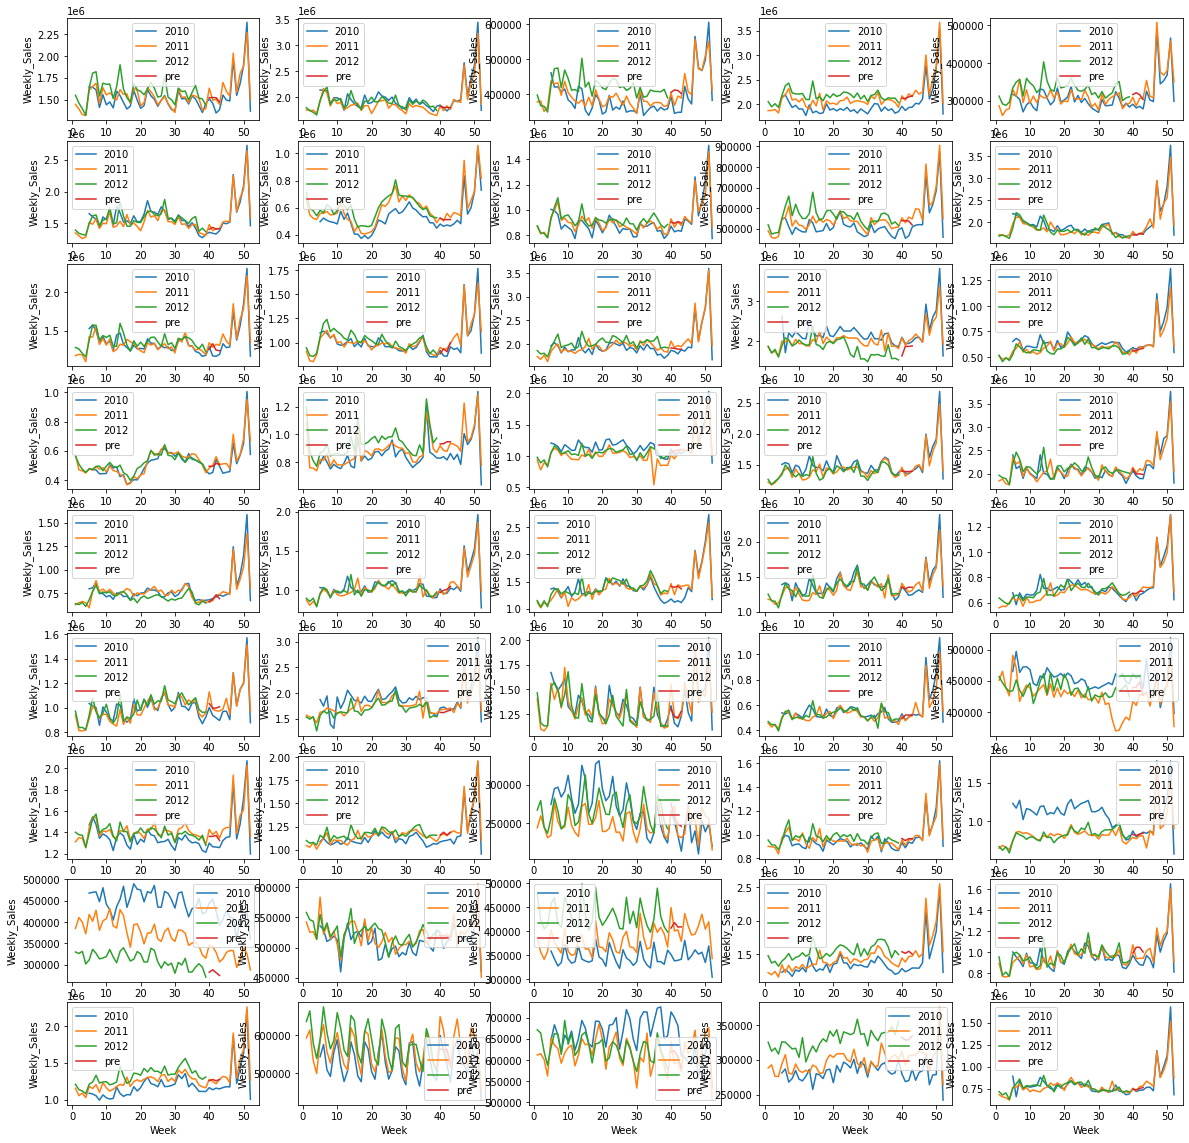

In [293]:
plt.figure(figsize=(20,20))
for i in range(1,46):
    plt.subplot(9,5,i)
    for j in [2010,2011,2012]:
        train_plt = train[(train['Store'] == i) & (train['Year'] == j)]
        sns.lineplot(train_plt['Week'], train_plt['Weekly_Sales'], label=j)
    sns.lineplot(hahaha['Week'], hahaha[hahaha['Store'] ==i]['Weekly_Sales'], label='pre')
plt.legend()
plt.show()

# modelling3

In [389]:
train_t = train.copy()
train_t = train_t[['Store', 'Temperature', 'Fuel_Price', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'Week', 'Year', 'Month', 'pro']]
x_train_t = train_t[['Store',
       'IsHoliday', 'Week', 'Year', 'Month']]

In [390]:
knr = KNeighborsRegressor(n_neighbors=4, leaf_size=30)
svr = SVR()
rfr = RandomForestRegressor(n_estimators=80, max_depth=None)
xgb = XGBRegressor(objective='reg:squarederror',max_depth=2, learning_rate=0.1, n_estimators=190)
cat = CatBoostRegressor(verbose=0)
lgbm = LGBMRegressor()

## tuning

### knr

In [391]:
knr_re_1 = []
knr_re_2 = []
knr_re_3 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = knr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    knr_re_1.append(re1)

    model = knr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    knr_re_2.append(re2)

    model = knr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    knr_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(knr_re_1),  np.mean(knr_re_2),  np.mean(knr_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 81235, re2 = 64162, re3 = 80274, select = 2011
 2 : re1 = 42582, re2 = 99959, re3 = 103683, select = 2010
 3 : re1 = 35539, re2 = 31135, re3 = 34741, select = 2011
 4 : re1 = 179183, re2 = 54255, re3 = 99570, select = 2011
 5 : re1 = 18541, re2 = 20101, re3 = 23001, select = 2010
 6 : re1 = 79680, re2 = 75305, re3 = 90056, select = 2011
 7 : re1 = 32071, re2 = 23264, re3 = 9917, select = 2012
 8 : re1 = 31290, re2 = 36390, re3 = 49455, select = 2010
 9 : re1 = 38969, re2 = 18343, re3 = 30298, select = 2011
10 : re1 = 24345, re2 = 34526, re3 = 32467, select = 2010
11 : re1 = 43438, re2 = 45164, re3 = 56404, select = 2010
12 : re1 = 26132, re2 = 32773, re3 = 30045, select = 2010
13 : re1 = 161185, re2 = 114594, re3 = 132240, select = 2011
14 : re1 = 316557, re2 = 334527, re3 = 305576, select = 2012
15 : re1 = 53338, re2 = 32561, re3 = 24093, select = 2012
16 : re1 = 32324, re2 = 29388, re3 = 20934, select = 2012
17 : re1 = 168512, re2 = 146135, re3 = 145313, select = 2012
18 :

### rfr

n_estimators=80, max_depth=None
mean : ree1 = 61230, ree2 = 46429, ree3 = 46521
all mean : 51393.33812421362


In [392]:
rfr_re_1 = []
rfr_re_2 = []
rfr_re_3 = []
rfr_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = rfr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    rfr_re_1.append(re1)

    model = rfr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    rfr_re_2.append(re2)

    model = rfr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    rfr_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    rfr_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(rfr_re_1),  np.mean(rfr_re_2),  np.mean(rfr_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 75018, re2 = 62263, re3 = 65512, select = 2011
 2 : re1 = 37312, re2 = 26580, re3 = 77736, select = 2011
 3 : re1 = 10039, re2 = 10600, re3 = 10055, select = 2010
 4 : re1 = 46879, re2 = 44525, re3 = 48522, select = 2011
 5 : re1 = 25952, re2 = 26441, re3 = 27373, select = 2010
 6 : re1 = 93397, re2 = 47494, re3 = 71765, select = 2011
 7 : re1 = 60167, re2 = 17810, re3 = 14348, select = 2012
 8 : re1 = 61908, re2 = 28061, re3 = 40013, select = 2011
 9 : re1 = 37487, re2 = 28986, re3 = 37884, select = 2011
10 : re1 = 32357, re2 = 38713, re3 = 29935, select = 2012
11 : re1 = 44835, re2 = 69102, re3 = 44280, select = 2012
12 : re1 = 23821, re2 = 27267, re3 = 19074, select = 2012
13 : re1 = 104485, re2 = 116998, re3 = 124071, select = 2010
14 : re1 = 156169, re2 = 143218, re3 = 150529, select = 2011
15 : re1 = 52743, re2 = 24241, re3 = 23961, select = 2012
16 : re1 = 24446, re2 = 13414, re3 = 11076, select = 2012
17 : re1 = 162551, re2 = 123959, re3 = 110649, select = 2012
18 : 

### xgb

max_depth=2, learning_rate=0.1, n_estimators=190

mean : ree1 = 43622, ree2 = 33045, ree3 = 34282
all mean : 36982.97174360151

In [393]:
xgb_re_1 = []
xgb_re_2 = []
xgb_re_3 = []
xgb_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_1.append(re1)

    model = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_2.append(re2)

    model = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xgb_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    xgb_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(xgb_re_1),  np.mean(xgb_re_2),  np.mean(xgb_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 40253, re2 = 51194, re3 = 52700, select = 2010
 2 : re1 = 42950, re2 = 58823, re3 = 59100, select = 2010
 3 : re1 = 9715, re2 = 9163, re3 = 8752, select = 2012
 4 : re1 = 36092, re2 = 20390, re3 = 19098, select = 2012
 5 : re1 = 15928, re2 = 10804, re3 = 12203, select = 2011
 6 : re1 = 95780, re2 = 43853, re3 = 56209, select = 2011
 7 : re1 = 31603, re2 = 18101, re3 = 15548, select = 2012
 8 : re1 = 34523, re2 = 22769, re3 = 29905, select = 2011
 9 : re1 = 17440, re2 = 16718, re3 = 16403, select = 2012
10 : re1 = 45805, re2 = 39750, re3 = 35784, select = 2012
11 : re1 = 40568, re2 = 34091, re3 = 38983, select = 2011
12 : re1 = 17506, re2 = 26096, re3 = 29474, select = 2010
13 : re1 = 113031, re2 = 114904, re3 = 101624, select = 2012
14 : re1 = 59589, re2 = 61415, re3 = 46214, select = 2012
15 : re1 = 41628, re2 = 20222, re3 = 19014, select = 2012
16 : re1 = 21138, re2 = 20800, re3 = 15944, select = 2012
17 : re1 = 106196, re2 = 112841, re3 = 110120, select = 2010
18 : re1 = 

### cat

In [404]:
cat_re_1 = []
cat_re_2 = []
cat_re_3 = []
cat_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model = cat.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    cat_re_1.append(re1)

    model = cat.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    cat_re_2.append(re2)

    model = cat.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre = model.predict(x_ttest)
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    cat_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    cat_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(cat_re_1),  np.mean(cat_re_2),  np.mean(cat_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 62807, re2 = 54664, re3 = 55096, select = 2011
 2 : re1 = 36068, re2 = 43646, re3 = 45085, select = 2010
 3 : re1 = 9982, re2 = 9140, re3 = 9959, select = 2011
 4 : re1 = 47223, re2 = 23323, re3 = 22419, select = 2012
 5 : re1 = 17770, re2 = 16372, re3 = 15143, select = 2012
 6 : re1 = 65780, re2 = 73259, re3 = 67160, select = 2010
 7 : re1 = 29987, re2 = 17038, re3 = 11922, select = 2012
 8 : re1 = 24156, re2 = 30531, re3 = 29095, select = 2010
 9 : re1 = 16081, re2 = 18268, re3 = 15391, select = 2012
10 : re1 = 28978, re2 = 29794, re3 = 20942, select = 2012
11 : re1 = 37407, re2 = 56615, re3 = 40933, select = 2010
12 : re1 = 33204, re2 = 41811, re3 = 44645, select = 2010
13 : re1 = 116920, re2 = 106284, re3 = 116354, select = 2011
14 : re1 = 98892, re2 = 96518, re3 = 89818, select = 2012
15 : re1 = 33482, re2 = 29264, re3 = 22106, select = 2012
16 : re1 = 24559, re2 = 12309, re3 = 9083, select = 2012
17 : re1 = 142517, re2 = 129509, re3 = 121133, select = 2012
18 : re1 = 4

## predict

In [407]:
xc_re_1 = []
xc_re_2 = []
xc_re_3 = []
xc_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model_x = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    model_c = cat.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre_x = model_x.predict(x_ttest)
    pre_c = model_c.predict(x_ttest)
    pre = (pre_x + pre_c)/2
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xc_re_1.append(re1)

    model_x = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    model_c = cat.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre_x = model_x.predict(x_ttest)
    pre_c = model_c.predict(x_ttest)
    pre = (pre_x + pre_c)/2
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xc_re_2.append(re2)

    model_x = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    model_c = cat.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre_x = model_x.predict(x_ttest)
    pre_c = model_c.predict(x_ttest)
    pre = (pre_x + pre_c)/2
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    xc_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    cat_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(cat_re_1),  np.mean(cat_re_2),  np.mean(cat_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 50593, re2 = 52592, re3 = 52808, select = 2010
 2 : re1 = 35894, re2 = 49949, re3 = 50982, select = 2010
 3 : re1 = 9790, re2 = 8825, re3 = 9124, select = 2011
 4 : re1 = 35780, re2 = 21242, re3 = 18350, select = 2012
 5 : re1 = 16359, re2 = 13548, re3 = 13166, select = 2012
 6 : re1 = 70838, re2 = 57177, re3 = 55812, select = 2012
 7 : re1 = 29716, re2 = 14237, re3 = 11392, select = 2012
 8 : re1 = 26749, re2 = 24375, re3 = 28370, select = 2011
 9 : re1 = 16145, re2 = 17226, re3 = 15893, select = 2012
10 : re1 = 31821, re2 = 28818, re3 = 25989, select = 2012
11 : re1 = 38677, re2 = 43854, re3 = 39524, select = 2010
12 : re1 = 23731, re2 = 33473, re3 = 36802, select = 2010
13 : re1 = 114856, re2 = 108513, re3 = 108639, select = 2011
14 : re1 = 58777, re2 = 43882, re3 = 51080, select = 2011
15 : re1 = 36998, re2 = 19574, re3 = 19675, select = 2011
16 : re1 = 22681, re2 = 9399, re3 = 8553, select = 2012
17 : re1 = 123872, re2 = 119842, re3 = 113769, select = 2012
18 : re1 = 46

In [395]:
all_re_1 = []
all_re_2 = []
all_re_3 = []
all_se = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=9) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <9) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] ==9) & (x_train_t['Year'] == 2012)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=9) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <9) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)

    y_ttest = train_t[(train_t['Store'] == i) & (train_t['Month'] ==9) & (train_t['Year'] == 2012)]
                          
    model_k = knr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    model_r = rfr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    model_x = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    model_c = cat.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre_k = model_k.predict(x_ttest)
    pre_r = model_r.predict(x_ttest)
    pre_x = model_x.predict(x_ttest)
    pre_c = model_c.predict(x_ttest)
    pre = (pre_k + pre_r + pre_x + pre_c)/4
    re1 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    all_re_1.append(re1)

    model_k = knr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    model_r = rfr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    model_x = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    model_c = cat.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre_k = model_k.predict(x_ttest)
    pre_r = model_r.predict(x_ttest)
    pre_x = model_x.predict(x_ttest)
    pre_c = model_c.predict(x_ttest)
    pre = (pre_k + pre_r + pre_x + pre_c)/4
    re2 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    all_re_2.append(re2)

    model_k = knr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    model_r = rfr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    model_x = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    model_c = cat.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre_k = model_k.predict(x_ttest)
    pre_r = model_r.predict(x_ttest)
    pre_x = model_x.predict(x_ttest)
    pre_c = model_c.predict(x_ttest)
    pre = (pre_k + pre_r + pre_x + pre_c)/4
    re3 = mean_squared_error(y_ttest['Weekly_Sales'] ,pre)**0.5
    all_re_3.append(re3)

    re_dif = [re1, re2, re3]
    select_year = np.argmin(re_dif)
    cat_se.append(select_year)
    print(f'{i:2} : re1 = {re1:.0f}, re2 = {re2:.0f}, re3 = {re3:.0f}, select = {select_year+2010}')
ree1, ree2, ree3 = np.mean(cat_re_1),  np.mean(cat_re_2),  np.mean(cat_re_3)
print(f'mean : ree1 = {ree1:.0f}, ree2 = {ree2:.0f}, ree3 = {ree3:.0f}')
print(f'all mean : {np.mean([ree1, ree2, ree3])}')

 1 : re1 = 57816, re2 = 52405, re3 = 51518, select = 2012
 2 : re1 = 33530, re2 = 48662, re3 = 68698, select = 2010
 3 : re1 = 11462, re2 = 11162, re3 = 12289, select = 2011
 4 : re1 = 52084, re2 = 25077, re3 = 27729, select = 2011
 5 : re1 = 17457, re2 = 14786, re3 = 13739, select = 2012
 6 : re1 = 77821, re2 = 56121, re3 = 59704, select = 2011
 7 : re1 = 30113, re2 = 15505, re3 = 9801, select = 2012
 8 : re1 = 17800, re2 = 18538, re3 = 20089, select = 2010
 9 : re1 = 15541, re2 = 15352, re3 = 12781, select = 2012
10 : re1 = 29682, re2 = 28519, re3 = 28862, select = 2011
11 : re1 = 38498, re2 = 40388, re3 = 35643, select = 2012
12 : re1 = 22694, re2 = 30680, re3 = 21500, select = 2012
13 : re1 = 112172, re2 = 97160, re3 = 95580, select = 2012
14 : re1 = 126695, re2 = 128037, re3 = 124047, select = 2012
15 : re1 = 44954, re2 = 23109, re3 = 22015, select = 2012
16 : re1 = 25964, re2 = 12405, re3 = 10106, select = 2012
17 : re1 = 139933, re2 = 119440, re3 = 119791, select = 2011
18 : re1

In [440]:
re_df3 = pd.DataFrame([knr_re_1,knr_re_2,knr_re_3,rfr_re_1,rfr_re_2,rfr_re_3,xgb_re_1,xgb_re_2,xgb_re_3,cat_re_1,cat_re_2,cat_re_3,xc_re_1,xc_re_2,xc_re_3,all_re_1,all_re_2,all_re_3])
re_df3 = re_df3.T
re_df3.columns = ['knr_10','knr_11','knr_1011','rfr_10','rfr_11','rfr_1011','xgb_10','xgb_11','xgb_1011','cat_10','cat_11','cat_1011','xc_10','xc_11','xc_1011','all_10','all_11','all_1011']
re_df3['min'] = re_df3.min(axis=1)
def select_ch(x):
    se = np.argmin(x.values)
    x['select'] = re_df3.columns[se]
    return x
re_df3 = re_df3.apply(select_ch, axis=1)
re_df3

,knr_10,knr_11,knr_1011,rfr_10,rfr_11,rfr_1011,xgb_10,xgb_11,xgb_1011,cat_10,cat_11,cat_1011,xc_10,xc_11,xc_1011,all_10,all_11,all_1011,min,select
0,81235.111728,64162.458050,80274.403225,75017.772368,62262.786356,65512.422504,40252.710884,51194.442230,52700.143242,62806.975663,54663.626170,55095.639546,50592.866866,52591.633136,52807.736924,57815.880634,52404.620756,51517.608522,40252.710884,xgb_10
1,42581.971845,99958.753388,103683.001565,37311.802058,26579.838268,77736.172785,42949.652260,58822.510498,59100.480326,36067.623193,43646.081649,45084.586292,35893.539654,49949.176278,50981.921828,33530.354326,48661.546396,68698.394318,26579.838268,rfr_11
2,35538.813644,31134.619928,34740.802573,10038.932816,10599.710538,10055.433444,9715.363159,9163.336481,8752.228681,9981.619456,9140.029631,9959.442826,9789.617879,8825.356694,9123.967635,11462.397182,11162.131936,12288.641263,8752.228681,xgb_1011
3,179182.584938,54254.934633,99569.767343,46879.438150,44525.488640,48522.415955,36091.811888,20390.454228,19098.251445,47223.227395,23323.413802,22418.515721,35779.516315,21241.642714,18350.285252,52083.780006,25077.361822,27729.196876,18350.285252,xc_1011
4,18541.365417,20101.183807,23001.328471,25951.793928,26440.610889,27373.453426,15927.954811,10804.266790,12202.995878,17769.969199,16372.032777,15142.545325,16358.834255,13547.787999,13166.390328,17456.620817,14785.944417,13738.919329,10804.266790,xgb_11
5,79679.750324,75305.186304,90056.497401,93397.448502,47493.672880,71765.267920,95780.130014,43853.332109,56209.103313,65779.633019,73258.530966,67159.715692,70837.507091,57177.389032,55812.483231,77821.297679,56121.170685,59703.653541,43853.332109,xgb_11
6,32071.171540,23264.195233,9917.237548,60167.186971,17810.203580,14347.992919,31603.034367,18101.219732,15547.599393,29986.915805,17037.758592,11921.998442,29716.094918,14236.828326,11391.629032,30112.838422,15504.964178,9800.628958,9800.628958,all_1011
7,31290.328025,36390.154346,49455.497728,61907.537837,28061.153541,40013.214591,34523.445946,22768.784435,29905.419770,24156.398619,30531.061200,29094.947187,26748.768261,24374.938602,28370.163715,17799.541531,18537.870932,20089.192496,17799.541531,all_10
8,38969.055924,18342.625822,30298.309681,37486.751435,28985.957809,37884.316470,17439.616000,16718.011930,16403.184385,16080.692604,18267.890324,15391.314118,16145.356584,17226.222131,15892.854570,15540.782404,15352.394495,12780.973044,12780.973044,all_1011
9,24345.386651,34525.780215,32466.749895,32357.476816,38712.555510,29934.825537,45804.709133,39750.240259,35784.155018,28978.485417,29793.685870,20941.814410,31821.114885,28817.672116,25989.413017,29682.162900,28518.716907,28861.695636,20941.814410,cat_1011


In [409]:
re_df3.select.value_counts()

xgb_11       10
cat_1011      7
xgb_1011      5
xgb_10        4
xc_1011       4
all_1011      3
xc_11         3
all_10        2
knr_re_10     2
cat_11        2
rfr_re_10     2
rfr_re_11     1
Name: select, dtype: int64

In [410]:
re_df3['min'].mean()

24322.75761535618

In [411]:
train_t = train.copy()
train_t = train_t[['Store', 'Temperature', 'Fuel_Price', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'Week', 'Year', 'Month', 'pro']]
x_train_t = train_t[['Store',
       'IsHoliday', 'Week', 'Year', 'Month']]

test_t = test.copy()
test_t = test_t[['Store', 'Temperature', 'Fuel_Price', 'Unemployment',
       'IsHoliday', 'Week', 'Year', 'Month', 'pro']]
x_test_t = test_t[['Store',
       'IsHoliday', 'Week', 'Year', 'Month']]

### knr

In [412]:
knr_pre_10 = []
knr_pre_11 = []
knr_pre_1011 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <10) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_test_t[(x_test_t['Store'] == i)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <10) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)
                          
    model1 = knr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre1 = model1.predict(x_ttest)
    knr_pre_10.append(pre1)

    model2 = knr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre2 = model2.predict(x_ttest)
    knr_pre_11.append(pre2)

    model3 = knr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre3 = model3.predict(x_ttest)
    knr_pre_1011.append(pre3)

### rfr

In [413]:
rfr_pre_10 = []
rfr_pre_11 = []
rfr_pre_1011 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <10) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_test_t[(x_test_t['Store'] == i)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <10) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)
                          
    model1 = rfr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre1 = model1.predict(x_ttest)
    rfr_pre_10.append(pre1)

    model2 = rfr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre2 = model2.predict(x_ttest)
    rfr_pre_11.append(pre2)

    model3 = rfr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre3 = model3.predict(x_ttest)
    rfr_pre_1011.append(pre3)

### xgb

In [416]:
xgb_pre_10 = []
xgb_pre_11 = []
xgb_pre_1011 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <10) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_test_t[(x_test_t['Store'] == i)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <10) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)
                          
    model1 = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre1 = model1.predict(x_ttest)
    xgb_pre_10.append(pre1)

    model2 = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre2 = model2.predict(x_ttest)
    xgb_pre_11.append(pre2)

    model3 = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre3 = model3.predict(x_ttest)
    xgb_pre_1011.append(pre3)

### cat

In [417]:
cat_pre_10 = []
cat_pre_11 = []
cat_pre_1011 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <10) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_test_t[(x_test_t['Store'] == i)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <10) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)
                          
    model1 = cat.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre1 = model1.predict(x_ttest)
    cat_pre_10.append(pre1)

    model2 = cat.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre2 = model2.predict(x_ttest)
    cat_pre_11.append(pre2)

    model3 = cat.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre3 = model3.predict(x_ttest)
    cat_pre_1011.append(pre3)

### xg+cat

In [421]:
xc_pre_10 = []
xc_pre_11 = []
xc_pre_1011 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <10) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_test_t[(x_test_t['Store'] == i)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <10) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)
                          
    model1_xg = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    model1_ca = cat.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre1_xg = model1_xg.predict(x_ttest)
    pre1_ca = model1_ca.predict(x_ttest)
    pre1 = (pre1_xg + pre1_ca)/2
    xc_pre_10.append(pre1)

    model2_xg = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    model2_ca = cat.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre2_xg = model2_xg.predict(x_ttest)
    pre2_ca = model2_ca.predict(x_ttest)
    pre2 = (pre2_xg + pre2_ca)/2
    xc_pre_11.append(pre2)

    model3_xg = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    model3_ca = cat.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre3_xg = model3_xg.predict(x_ttest)
    pre3_ca = model3_ca.predict(x_ttest)
    pre3 = (pre3_xg + pre3_ca)/2
    xc_pre_1011.append(pre3)

### all

In [422]:
all_pre_10 = []
all_pre_11 = []
all_pre_1011 = []
for i in range(1,46):
    x_train_2010 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2010)]
    x_train_2011 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <=10) & (x_train_t['Year'] == 2011)]
    x_train_2012 = x_train_t[(x_train_t['Store'] == i) & (x_train_t['Month'] <10) & (x_train_t['Year'] == 2012)]
    
    x_ttrain_1 = pd.concat([x_train_2010, x_train_2012], axis=0)
    x_ttrain_2 = pd.concat([x_train_2011, x_train_2012], axis=0)
    x_ttrain_3 = pd.concat([x_train_2010, x_train_2011, x_train_2012], axis=0)

    x_ttest = x_test_t[(x_test_t['Store'] == i)]

    y_train_2010 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2010)]
    y_train_2011 = train_t[(train_t['Store'] == i) & (train_t['Month'] <=10) & (train_t['Year'] == 2011)]
    y_train_2012 = train_t[(train_t['Store'] == i) & (train_t['Month'] <10) & (train_t['Year'] == 2012)]

    y_ttrain_1 = pd.concat([y_train_2010, y_train_2012], axis=0)
    y_ttrain_2 = pd.concat([y_train_2011, y_train_2012], axis=0)
    y_ttrain_3 = pd.concat([y_train_2010, y_train_2011, y_train_2012], axis=0)
                          
    model1_knr = knr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    model1_rfr = rfr.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    model1_xg = xgb.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    model1_ca = cat.fit(x_ttrain_1, y_ttrain_1['Weekly_Sales'])
    pre1_knr = model1_knr.predict(x_ttest)
    pre1_rfr = model1_rfr.predict(x_ttest)
    pre1_xg = model1_xg.predict(x_ttest)
    pre1_ca = model1_ca.predict(x_ttest)
    pre1 = (pre1_knr + pre1_rfr + pre1_xg + pre1_ca)/4
    all_pre_10.append(pre1)

    model2_knr = knr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    model2_rfr = rfr.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    model2_xg = xgb.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    model2_ca = cat.fit(x_ttrain_2, y_ttrain_2['Weekly_Sales'])
    pre2_knr = model2_knr.predict(x_ttest)
    pre2_rfr = model2_rfr.predict(x_ttest)
    pre2_xg = model2_xg.predict(x_ttest)
    pre2_ca = model2_ca.predict(x_ttest)
    pre2 = (pre2_knr + pre2_rfr + pre2_xg + pre2_ca)/4
    all_pre_11.append(pre1)

    model3_knr = knr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    model3_rfr = rfr.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    model3_xg = xgb.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    model3_ca = cat.fit(x_ttrain_3, y_ttrain_3['Weekly_Sales'])
    pre3_knr = model3_knr.predict(x_ttest)
    pre3_rfr = model3_rfr.predict(x_ttest)
    pre3_xg = model3_xg.predict(x_ttest)
    pre3_ca = model3_ca.predict(x_ttest)
    pre3 = (pre3_knr + pre3_rfr + pre3_xg + pre3_ca)/4
    all_pre_1011.append(pre3)

## sub

In [448]:
re_df3.select.value_counts()

xgb_11      10
cat_1011     7
xgb_1011     5
xgb_10       4
xc_1011      4
all_1011     3
xc_11        3
all_10       2
knr_10       2
cat_11       2
rfr_10       2
rfr_11       1
Name: select, dtype: int64

In [449]:
re_fi = []
for i in range(45):
    select = re_df3.loc[i,'select']
    if select == 'knr_10':
        for j in knr_pre_10[i]:
            re_fi.append(j)
    elif select == 'knr_11':
        for j in knr_pre_11[i]:
            re_fi.append(j)
    elif select == 'knr_1011':
        for j in knr_pre_1011[i]:
            re_fi.append(j)
    elif select == 'rfr_10':
        for j in rfr_pre_10[i]:
            re_fi.append(j)
    elif select == 'rfr_11':
        for j in rfr_pre_11[i]:
            re_fi.append(j)
    elif select == 'rfr_1011':
        for j in rfr_pre_1011[i]:
            re_fi.append(j)
    elif select == 'xgb_10':
        for j in xgb_pre_10[i]:
            re_fi.append(j)
    elif select == 'xgb_11':
        for j in xgb_pre_11[i]:
            re_fi.append(j)
    elif select == 'xgb_1011':
        for j in xgb_pre_1011[i]:
            re_fi.append(j)
    elif select == 'cat_10':
        for j in cat_pre_10[i]:
            re_fi.append(j)
    elif select == 'cat_11':
        for j in cat_pre_11[i]:
            re_fi.append(j)
    elif select == 'cat_1011':
        for j in cat_pre_1011[i]:
            re_fi.append(j)
    elif select == 'xc_10':
        for j in xc_pre_10[i]:
            re_fi.append(j)
    elif select == 'xc_11':
        for j in xc_pre_11[i]:
            re_fi.append(j)
    elif select == 'xc_1011':
        for j in xc_pre_1011[i]:
            re_fi.append(j)
    elif select == 'all_10':
        for j in all_pre_10[i]:
            re_fi.append(j)
    elif select == 'all_11':
        for j in all_pre_11[i]:
            re_fi.append(j)
    elif select == 'all_1011':
        for j in all_pre_1011[i]:
            re_fi.append(j)

In [450]:
re_fi

[1521519.1,
 1521519.1,
 1453535.9,
 1470247.2,
 1796410.603625001,
 1785872.589125001,
 1791892.0531250003,
 1780267.904625001,
 428509.94,
 407642.75,
 412309.88,
 412309.88,
 2146148.9801415056,
 2113420.1864829035,
 2163145.779089543,
 2158044.989892426,
 316085.94,
 308619.5,
 317928.06,
 317928.06,
 1469423.4,
 1422734.1,
 1422734.1,
 1422734.1,
 519630.6649711578,
 516811.57261370454,
 531176.575692029,
 523010.1232173667,
 880425.4524242315,
 879128.9767554016,
 875643.0874105783,
 875557.6128425151,
 541219.5875689087,
 535092.3019526387,
 540581.4146224913,
 541840.3046836554,
 1750688.662624276,
 1712519.8198339713,
 1731251.560354668,
 1741438.0970303041,
 1320070.9,
 1301875.2,
 1304347.4,
 1303626.1,
 925285.9,
 899826.5,
 899826.5,
 966083.44,
 1993077.8829064523,
 1965333.3196294988,
 1957022.813041867,
 1955612.7441951823,
 1694272.3123169378,
 1635541.7592963963,
 1687989.842261908,
 1708492.1542437673,
 553902.0,
 548633.3,
 575583.44,
 575583.44,
 471470.2037994788,

In [451]:
len(re_fi)

180

In [452]:
sub = pd.read_csv('/content/sample_submission.csv')
sub['Weekly_Sales']=re_fi

In [455]:
sub.to_csv('submission.csv', index=False)

In [456]:
hahaha2 = pd.concat([x_test_t, sub['Weekly_Sales']], axis = 1)

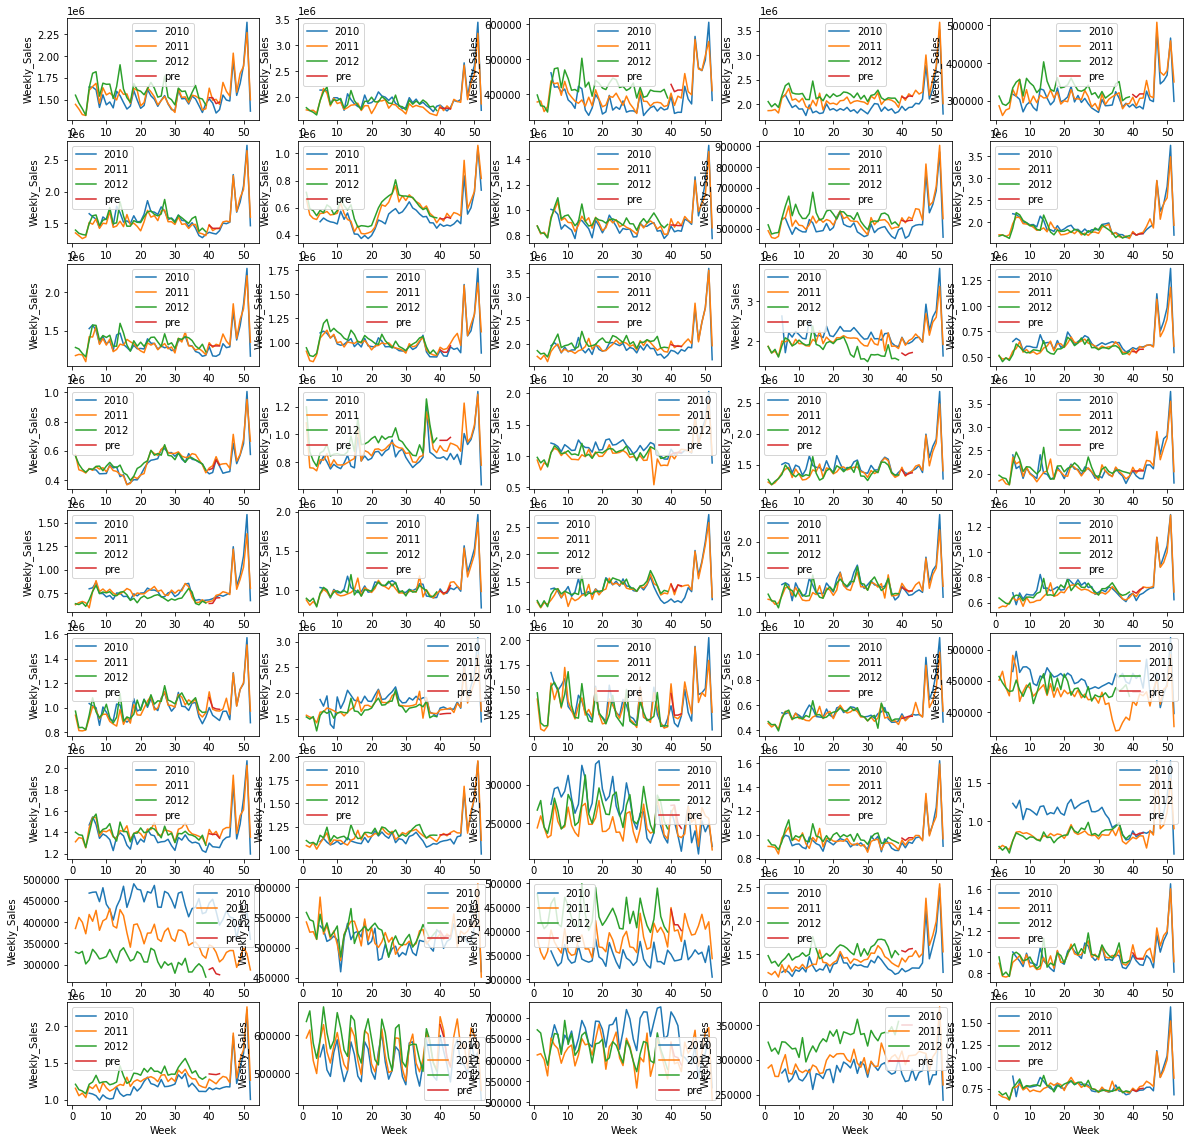

In [457]:
plt.figure(figsize=(20,20))
for i in range(1,46):
    plt.subplot(9,5,i)
    for j in [2010,2011,2012]:
        train_plt = train[(train['Store'] == i) & (train['Year'] == j)]
        sns.lineplot(train_plt['Week'], train_plt['Weekly_Sales'], label=j)
    sns.lineplot(hahaha2['Week'], hahaha2[hahaha2['Store'] ==i]['Weekly_Sales'], label='pre')
plt.legend()
plt.show()